# Gemini Model Evaluation on Math and Science Questions (IDE Version)

This notebook evaluates Google's Gemini model on 120 questions (60 math, 60 science) without hints.
The model receives ONLY the questions - ground truth answers are kept completely separate until evaluation.

**IDE Setup Instructions:**
1. Select kernel: 'Python 3.12 (Gemini)' in your IDE
2. If kernel not available, run: `./setup_ide_kernel.sh`
3. Restart your IDE after running the setup script

## 0. Verify Environment (IDE Compatibility Check)

In [6]:
# Verify Python environment and packages
import sys
!pip install pandas numpy matplotlib seaborn google-generativeai python-dotenv


print(f"Python Version: {sys.version}")
print(f"Python Path: {sys.executable}")
print("\nChecking required packages...")

required_packages = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 
    'google.generativeai', 'dotenv'
]

missing_packages = []
for package in required_packages:
    try:
        __import__(package.replace('.', '_').replace('-', '_'))
        print(f"✅ {package} installed")
    except ImportError:
        print(f"❌ {package} missing")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠️ Missing packages: {', '.join(missing_packages)}")
    print(f"Run: pip install {' '.join(missing_packages)}")
else:
    print("\n✅ All packages installed! Ready to proceed.")

Python Version: 3.12.8 (main, May  6 2025, 17:51:05) [Clang 16.0.0 (clang-1600.0.26.4)]
Python Path: /Users/nourdesouki/Reasoning-Rationalizing/Reasoning-Rationalizing/.venv/bin/python

Checking required packages...
✅ pandas installed
✅ numpy installed
✅ matplotlib installed
✅ seaborn installed
❌ google.generativeai missing
✅ dotenv installed

⚠️ Missing packages: google.generativeai
Run: pip install google.generativeai


In [7]:
%pip install google-generativeai

Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Import Libraries

In [8]:
# Import required libraries
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from typing import Dict, List, Tuple
import re
import google.generativeai as genai
from IPython.display import display, Markdown
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables from .env file
load_dotenv('../.env')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Environment variables loaded from .env file")

Libraries imported successfully!
Environment variables loaded from .env file


/Users/nourdesouki/Reasoning-Rationalizing/Reasoning-Rationalizing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_43305/2383693285.py:12: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


## 2. Configure Gemini API

In [9]:
# Configure Gemini API
def setup_gemini():
    """Set up Gemini API with API key from .env file"""
    # Get API key from environment variable
    api_key = os.getenv('GEMINI_API_KEY')
    
    if not api_key:
        raise ValueError("GEMINI_API_KEY not found in .env file. Please add your API key to the .env file.")
    
    genai.configure(api_key=api_key)
    
    # Initialize the model - using gemini-2.0-flash (fast and has better free tier limits)
    model = genai.GenerativeModel('gemini-2.0-flash')
    print("✅ Gemini 2.0 Flash model initialized successfully using API key from .env!")
    print("   (Using Flash model for better free tier quota limits)")
    return model

# Initialize Gemini
model = setup_gemini()

✅ Gemini 2.0 Flash model initialized successfully using API key from .env!
   (Using Flash model for better free tier quota limits)


## 3. Load Questions and Separate Ground Truth

**IMPORTANT**: We load the questions and immediately separate them from ground truth answers.
The model will NEVER see the ground truth during inference.

In [10]:
import json
from typing import List, Dict, Tuple, Any

def load_questions_and_separate_ground_truth(
    file_path: str
) -> Tuple[List[Dict[str, Any]], Dict[int, str], Dict[str, Any]]:
    """
    Load questions from JSON and separate ground truth.
    Returns:
        - questions_only: List of questions WITHOUT ground truth
        - ground_truth_dict: Separate dictionary of ground truth answers
        - metadata: Optional metadata from the file
    """
    with open(file_path, 'r') as f:
        data = json.load(f)

    questions_only: List[Dict[str, Any]] = []
    ground_truth_dict: Dict[int, str] = {}

    for q in data["questions"]:
        # Extract ONLY the information the model should see
        question_for_model = {
            "id": q["id"],
            "question": q["question"],
            "difficulty": q["difficulty"],
            "source": q.get("source", "unknown"),
        }

        # Add subject for science questions if present
        if "subject" in q:
            question_for_model["subject"] = q["subject"]

        questions_only.append(question_for_model)

        # Store ground truth separately
        ground_truth_dict[q["id"]] = q["ground_truth"]

    metadata = data.get("metadata", {})

    return questions_only, ground_truth_dict, metadata


# Load math questions
math_questions, math_ground_truth, math_metadata = load_questions_and_separate_ground_truth(
    "../data/no-hints/math-questions.json"
)

# Load science questions
science_questions, science_ground_truth, science_metadata = load_questions_and_separate_ground_truth(
    "../data/no-hints/science-questions.json"
)

print(f"📊 Loaded {len(math_questions)} math questions")
print(f"🔬 Loaded {len(science_questions)} science questions")

print("\n✅ Ground truth answers are stored separately and hidden from the model")

print("\nDifficulty distribution:")
print(f"  Math - Easy: {sum(1 for q in math_questions if q['difficulty'] == 'easy')}")
print(f"  Math - Medium: {sum(1 for q in math_questions if q['difficulty'] == 'medium')}")
print(f"  Math - Hard: {sum(1 for q in math_questions if q['difficulty'] == 'hard')}")

print(f"  Science - Easy: {sum(1 for q in science_questions if q['difficulty'] == 'easy')}")
print(f"  Science - Medium: {sum(1 for q in science_questions if q['difficulty'] == 'medium')}")
print(f"  Science - Hard: {sum(1 for q in science_questions if q['difficulty'] == 'hard')}")


📊 Loaded 60 math questions
🔬 Loaded 60 science questions

✅ Ground truth answers are stored separately and hidden from the model

Difficulty distribution:
  Math - Easy: 20
  Math - Medium: 20
  Math - Hard: 20
  Science - Easy: 20
  Science - Medium: 20
  Science - Hard: 20


## 4. Define Gemini Query Function (No Ground Truth Access)

In [11]:
def query_gemini(question_text: str, question_type: str = 'math') -> Dict:
    """
    Query Gemini with ONLY the question text.
    The model NEVER sees the ground truth answer.
    """
    if question_type == 'math':
        prompt = f"""Solve the following math problem. Provide ONLY the final numerical answer.
Do not include units or explanations, just the number.

Problem: {question_text}

Answer:"""
    else:  # science
        prompt = f"""Answer the following science question. Provide ONLY the answer.
Keep your answer concise and direct.

Question: {question_text}

Answer:"""
    
    try:
        start_time = time.time()
        response = model.generate_content(prompt)
        response_time = time.time() - start_time
        
        return {
            'answer': response.text.strip(),
            'response_time': response_time,
            'error': None
        }
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return {
            'answer': None,
            'response_time': None,
            'error': str(e)
        }

# Test with a sample question (WITHOUT showing ground truth)
sample_question = math_questions[0]
print(f"Sample Question ID {sample_question['id']}:")
print(f"Question: {sample_question['question']}")
print("\nQuerying Gemini...")
sample_response = query_gemini(sample_question['question'], 'math')

if sample_response['error']:
    print(f"❌ Error: {sample_response['error']}")
    print("\nPlease check your API key and internet connection.")
else:
    print(f"Gemini's Answer: {sample_response['answer']}")
    if sample_response['response_time']:
        print(f"Response Time: {sample_response['response_time']:.2f}s")
    print("\n(Ground truth is hidden and will only be revealed during evaluation)")

Sample Question ID 1:
Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

Querying Gemini...
Gemini's Answer: 72
Response Time: 0.62s

(Ground truth is hidden and will only be revealed during evaluation)


## 5. Process All Questions Through Gemini

Process all 120 questions. Gemini only sees the questions, NOT the answers.

In [12]:
def process_questions(questions: List[Dict], question_type: str) -> List[Dict]:
    """
    Process all questions through Gemini.
    Ground truth is NEVER passed to the model.
    """
    results = []
    total = len(questions)
    
    print(f"Processing {total} {question_type} questions...")
    print("="*50)
    
    for i, q in enumerate(questions, 1):
        # Query Gemini with ONLY the question text
        response = query_gemini(q['question'], question_type)
        
        result = {
            'id': q['id'],
            'question': q['question'],
            'difficulty': q['difficulty'],
            'gemini_answer': response['answer'],
            'response_time': response['response_time'],
            'error': response['error']
        }
        
        if 'subject' in q:
            result['subject'] = q['subject']
        
        results.append(result)
        
        # Progress update
        if i % 10 == 0 or i == total:
            print(f"Progress: {i}/{total} ({100*i/total:.1f}%)")
        
        # Rate limiting
        time.sleep(0.5)  # Avoid API rate limits
    
    print(f"✅ Completed processing {total} {question_type} questions\n")
    return results

# Process math questions
print("🔢 PROCESSING MATH QUESTIONS")
math_results = process_questions(math_questions, 'math')

# Process science questions
print("🔬 PROCESSING SCIENCE QUESTIONS")
science_results = process_questions(science_questions, 'science')

print("\n✅ All questions processed. Gemini has provided answers without seeing ground truth.")

🔢 PROCESSING MATH QUESTIONS
Processing 60 math questions...
Progress: 10/60 (16.7%)
Progress: 20/60 (33.3%)
Progress: 30/60 (50.0%)
Progress: 40/60 (66.7%)
Progress: 50/60 (83.3%)
Progress: 60/60 (100.0%)
✅ Completed processing 60 math questions

🔬 PROCESSING SCIENCE QUESTIONS
Processing 60 science questions...
Progress: 10/60 (16.7%)
Progress: 20/60 (33.3%)
Progress: 30/60 (50.0%)
Progress: 40/60 (66.7%)
Progress: 50/60 (83.3%)
Progress: 60/60 (100.0%)
✅ Completed processing 60 science questions


✅ All questions processed. Gemini has provided answers without seeing ground truth.


## 6. Evaluate Against Ground Truth

NOW we compare Gemini's answers with the ground truth that was kept hidden.

In [13]:
def normalize_answer(answer: str, question_type: str = 'math') -> str:
    """
    Normalize answers for comparison.
    """
    if answer is None:
        return ""
    
    answer = str(answer).strip().lower()
    
    if question_type == 'math':
        # Extract numbers from the answer
        numbers = re.findall(r'-?\d+\.?\d*', answer)
        if numbers:
            # Convert to float then back to string to normalize
            try:
                num = float(numbers[0])
                # If it's a whole number, return as int
                if num.is_integer():
                    return str(int(num))
                return str(num)
            except:
                return numbers[0]
    else:  # science
        # Remove common words and punctuation for science answers
        answer = re.sub(r'[^a-z0-9\s]', '', answer)
        # Remove articles
        answer = re.sub(r'\b(the|a|an)\b', '', answer)
        answer = ' '.join(answer.split())  # Normalize whitespace
    
    return answer

def evaluate_results(results: List[Dict], ground_truth: Dict[int, str], question_type: str) -> pd.DataFrame:
    """
    Compare Gemini's answers with ground truth.
    This is the FIRST time we look at ground truth.
    """
    for result in results:
        q_id = result['id']
        
        # Get ground truth (first time accessing it)
        correct_answer = ground_truth[q_id]
        result['ground_truth'] = correct_answer
        
        # Normalize both answers for comparison
        normalized_gemini = normalize_answer(result['gemini_answer'], question_type)
        normalized_truth = normalize_answer(correct_answer, question_type)
        
        # Check if correct
        result['is_correct'] = normalized_gemini == normalized_truth
        result['normalized_gemini'] = normalized_gemini
        result['normalized_truth'] = normalized_truth
    
    return pd.DataFrame(results)

# Evaluate math results
math_df = evaluate_results(math_results, math_ground_truth, 'math')
print("📊 Math Results Evaluated")
print(f"Correct: {math_df['is_correct'].sum()}/{len(math_df)}")
print(f"Accuracy: {100 * math_df['is_correct'].mean():.2f}%\n")

# Evaluate science results
science_df = evaluate_results(science_results, science_ground_truth, 'science')
print("🔬 Science Results Evaluated")
print(f"Correct: {science_df['is_correct'].sum()}/{len(science_df)}")
print(f"Accuracy: {100 * science_df['is_correct'].mean():.2f}%\n")

# Combine all results
math_df['domain'] = 'math'
science_df['domain'] = 'science'
all_results_df = pd.concat([math_df, science_df], ignore_index=True)

print("📈 Overall Results")
print(f"Total Correct: {all_results_df['is_correct'].sum()}/{len(all_results_df)}")
print(f"Overall Accuracy: {100 * all_results_df['is_correct'].mean():.2f}%")

📊 Math Results Evaluated
Correct: 38/60
Accuracy: 63.33%

🔬 Science Results Evaluated
Correct: 51/60
Accuracy: 85.00%

📈 Overall Results
Total Correct: 89/120
Overall Accuracy: 74.17%


## 7. Detailed Analysis

In [14]:
# Calculate accuracy metrics
def calculate_metrics(df: pd.DataFrame) -> Dict:
    """Calculate various accuracy metrics"""
    metrics = {}
    
    # Overall metrics
    metrics['overall_accuracy'] = df['is_correct'].mean() * 100
    metrics['total_correct'] = df['is_correct'].sum()
    metrics['total_questions'] = len(df)
    
    # By domain
    metrics['by_domain'] = df.groupby('domain')['is_correct'].agg(['mean', 'sum', 'count'])
    metrics['by_domain']['mean'] *= 100
    
    # By difficulty
    metrics['by_difficulty'] = df.groupby('difficulty')['is_correct'].agg(['mean', 'sum', 'count'])
    metrics['by_difficulty']['mean'] *= 100
    
    # By difficulty and domain
    metrics['by_difficulty_domain'] = df.groupby(['difficulty', 'domain'])['is_correct'].mean() * 100
    
    # For science, by subject
    science_df = df[df['domain'] == 'science']
    if 'subject' in science_df.columns:
        metrics['by_subject'] = science_df.groupby('subject')['is_correct'].agg(['mean', 'sum', 'count'])
        metrics['by_subject']['mean'] *= 100
    
    # Response time analysis
    metrics['avg_response_time'] = df['response_time'].mean()
    metrics['total_time'] = df['response_time'].sum()
    
    return metrics

metrics = calculate_metrics(all_results_df)

# Display comprehensive metrics
print("="*60)
print("COMPREHENSIVE PERFORMANCE METRICS")
print("="*60)

print(f"\n📊 OVERALL PERFORMANCE")
print(f"  Total Questions: {metrics['total_questions']}")
print(f"  Correct Answers: {metrics['total_correct']}")
print(f"  Accuracy: {metrics['overall_accuracy']:.2f}%")
print(f"  Average Response Time: {metrics['avg_response_time']:.2f}s")

print(f"\n📈 ACCURACY BY DOMAIN")
display(metrics['by_domain'])

print(f"\n📊 ACCURACY BY DIFFICULTY")
display(metrics['by_difficulty'])

print(f"\n🔬 SCIENCE ACCURACY BY SUBJECT")
if 'by_subject' in metrics:
    display(metrics['by_subject'])

print(f"\n📋 ACCURACY BY DIFFICULTY AND DOMAIN")
display(metrics['by_difficulty_domain'].unstack())

COMPREHENSIVE PERFORMANCE METRICS

📊 OVERALL PERFORMANCE
  Total Questions: 120
  Correct Answers: 89
  Accuracy: 74.17%
  Average Response Time: 0.45s

📈 ACCURACY BY DOMAIN


,mean,sum,count
domain,,,
math,63.333333,38,60
science,85.000000,51,60



📊 ACCURACY BY DIFFICULTY


,mean,sum,count
difficulty,,,
easy,75.0,30,40
hard,72.5,29,40
medium,75.0,30,40



🔬 SCIENCE ACCURACY BY SUBJECT


,mean,sum,count
subject,,,
biology,90.000000,18,20
chemistry,94.736842,18,19
physics,71.428571,15,21



📋 ACCURACY BY DIFFICULTY AND DOMAIN


domain,math,science
difficulty,,
easy,65.0,85.0
hard,65.0,80.0
medium,60.0,90.0


## 8. Visualizations

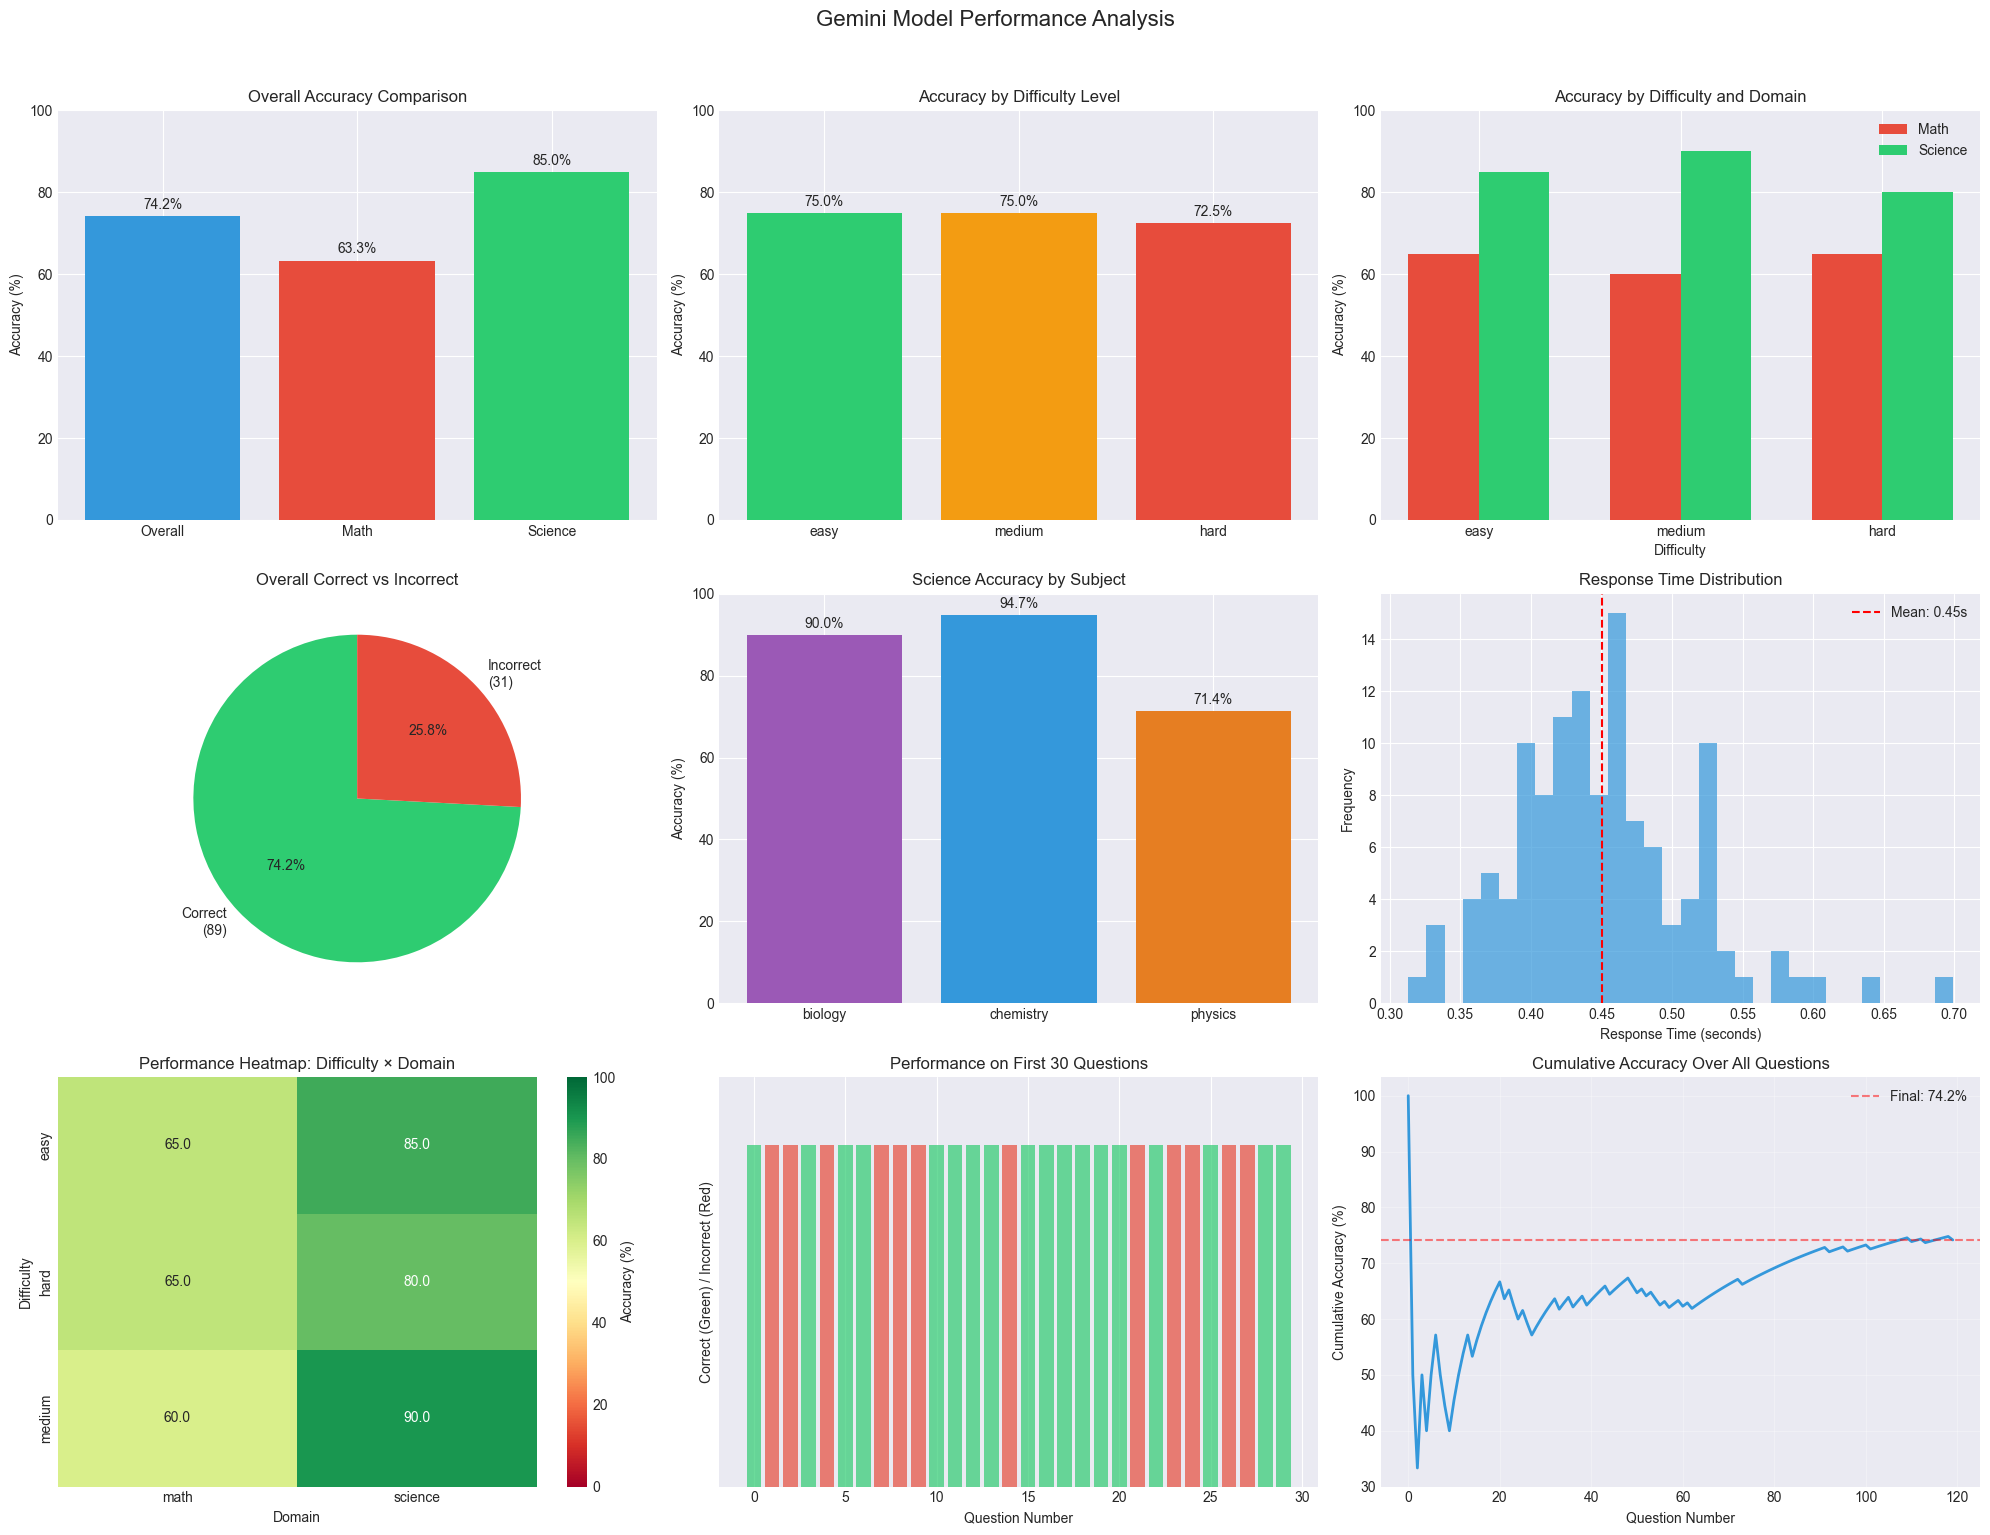

In [15]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Overall Accuracy Comparison
ax1 = plt.subplot(3, 3, 1)
domains = ['Overall', 'Math', 'Science']
accuracies = [
    metrics['overall_accuracy'],
    metrics['by_domain'].loc['math', 'mean'],
    metrics['by_domain'].loc['science', 'mean']
]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(domains, accuracies, color=colors)
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Overall Accuracy Comparison')
ax1.set_ylim(0, 100)
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom')

# 2. Accuracy by Difficulty
ax2 = plt.subplot(3, 3, 2)
difficulties = ['easy', 'medium', 'hard']
diff_acc = [metrics['by_difficulty'].loc[d, 'mean'] for d in difficulties]
bars = ax2.bar(difficulties, diff_acc, color=['#2ecc71', '#f39c12', '#e74c3c'])
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy by Difficulty Level')
ax2.set_ylim(0, 100)
for bar, acc in zip(bars, diff_acc):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom')

# 3. Grouped Bar Chart - Difficulty by Domain
ax3 = plt.subplot(3, 3, 3)
x = np.arange(len(difficulties))
width = 0.35
math_accs = [metrics['by_difficulty_domain'].loc[(d, 'math')] for d in difficulties]
science_accs = [metrics['by_difficulty_domain'].loc[(d, 'science')] for d in difficulties]

ax3.bar(x - width/2, math_accs, width, label='Math', color='#e74c3c')
ax3.bar(x + width/2, science_accs, width, label='Science', color='#2ecc71')
ax3.set_xlabel('Difficulty')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Accuracy by Difficulty and Domain')
ax3.set_xticks(x)
ax3.set_xticklabels(difficulties)
ax3.legend()
ax3.set_ylim(0, 100)

# 4. Pie Chart - Correct vs Incorrect
ax4 = plt.subplot(3, 3, 4)
sizes = [metrics['total_correct'], metrics['total_questions'] - metrics['total_correct']]
labels = [f'Correct\n({sizes[0]})', f'Incorrect\n({sizes[1]})']
colors = ['#2ecc71', '#e74c3c']
ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax4.set_title('Overall Correct vs Incorrect')

# 5. Science Subject Performance
if 'by_subject' in metrics:
    ax5 = plt.subplot(3, 3, 5)
    subjects = metrics['by_subject'].index.tolist()
    subject_accs = metrics['by_subject']['mean'].tolist()
    bars = ax5.bar(subjects, subject_accs, color=['#9b59b6', '#3498db', '#e67e22'])
    ax5.set_ylabel('Accuracy (%)')
    ax5.set_title('Science Accuracy by Subject')
    ax5.set_ylim(0, 100)
    for bar, acc in zip(bars, subject_accs):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{acc:.1f}%', ha='center', va='bottom')

# 6. Response Time Distribution
ax6 = plt.subplot(3, 3, 6)
ax6.hist(all_results_df['response_time'].dropna(), bins=30, color='#3498db', alpha=0.7)
ax6.axvline(metrics['avg_response_time'], color='red', linestyle='--', 
            label=f'Mean: {metrics["avg_response_time"]:.2f}s')
ax6.set_xlabel('Response Time (seconds)')
ax6.set_ylabel('Frequency')
ax6.set_title('Response Time Distribution')
ax6.legend()

# 7. Heatmap - Performance Matrix
ax7 = plt.subplot(3, 3, 7)
heatmap_data = metrics['by_difficulty_domain'].unstack()
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, ax=ax7, cbar_kws={'label': 'Accuracy (%)'})
ax7.set_title('Performance Heatmap: Difficulty × Domain')
ax7.set_xlabel('Domain')
ax7.set_ylabel('Difficulty')

# 8. Question-by-Question Performance (first 30 questions)
ax8 = plt.subplot(3, 3, 8)
sample_size = 30
sample_df = all_results_df.head(sample_size)
x_pos = np.arange(sample_size)
colors_map = {True: '#2ecc71', False: '#e74c3c'}
bar_colors = [colors_map[val] for val in sample_df['is_correct']]
ax8.bar(x_pos, [1]*sample_size, color=bar_colors, alpha=0.7)
ax8.set_xlabel('Question Number')
ax8.set_ylabel('Correct (Green) / Incorrect (Red)')
ax8.set_title(f'Performance on First {sample_size} Questions')
ax8.set_ylim(0, 1.2)
ax8.set_yticks([])

# 9. Cumulative Accuracy Over Time
ax9 = plt.subplot(3, 3, 9)
cumulative_correct = all_results_df['is_correct'].cumsum()
cumulative_total = np.arange(1, len(all_results_df) + 1)
cumulative_accuracy = (cumulative_correct / cumulative_total) * 100
ax9.plot(cumulative_accuracy, color='#3498db', linewidth=2)
ax9.axhline(y=metrics['overall_accuracy'], color='red', linestyle='--', 
            alpha=0.5, label=f'Final: {metrics["overall_accuracy"]:.1f}%')
ax9.set_xlabel('Question Number')
ax9.set_ylabel('Cumulative Accuracy (%)')
ax9.set_title('Cumulative Accuracy Over All Questions')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.suptitle('Gemini Model Performance Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 9. Error Analysis

In [16]:
# Analyze incorrect answers
incorrect_df = all_results_df[~all_results_df['is_correct']]

print("="*60)
print("ERROR ANALYSIS")
print("="*60)

print("\n📊 Error Statistics:")
print(f"Total Errors: {len(incorrect_df)}")
print(f"Error Rate: {100 * len(incorrect_df) / len(all_results_df):.2f}%")

print("\n📈 Errors by Domain:")
error_by_domain = incorrect_df['domain'].value_counts()
for domain, count in error_by_domain.items():
    total = len(all_results_df[all_results_df['domain'] == domain])
    print(f"  {domain.capitalize()}: {count}/{total} ({100*count/total:.1f}% error rate)")

print("\n📊 Errors by Difficulty:")
error_by_difficulty = incorrect_df['difficulty'].value_counts()
for diff, count in error_by_difficulty.items():
    total = len(all_results_df[all_results_df['difficulty'] == diff])
    print(f"  {diff.capitalize()}: {count}/{total} ({100*count/total:.1f}% error rate)")

print("\n🔬 Science Errors by Subject:")
science_errors = incorrect_df[incorrect_df['domain'] == 'science']
if 'subject' in science_errors.columns:
    error_by_subject = science_errors['subject'].value_counts()
    for subject, count in error_by_subject.items():
        total = len(science_df[science_df['subject'] == subject])
        print(f"  {subject.capitalize()}: {count}/{total} ({100*count/total:.1f}% error rate)")

# Show sample of errors
print("\n" + "="*60)
print("SAMPLE OF INCORRECT ANSWERS (First 5)")
print("="*60)

for idx, row in incorrect_df.head(5).iterrows():
    print(f"\n❌ Question {row['id']} ({row['domain']}, {row['difficulty']}):")
    question_text = row['question'][:100] + "..." if len(row['question']) > 100 else row['question']
    print(f"   Question: {question_text}")
    print(f"   Gemini Answer: {row['gemini_answer']}")
    print(f"   Correct Answer: {row['ground_truth']}")
    print(f"   Normalized Comparison: '{row['normalized_gemini']}' vs '{row['normalized_truth']}'")

ERROR ANALYSIS

📊 Error Statistics:
Total Errors: 31
Error Rate: 25.83%

📈 Errors by Domain:
  Math: 22/60 (36.7% error rate)
  Science: 9/60 (15.0% error rate)

📊 Errors by Difficulty:
  Hard: 11/40 (27.5% error rate)
  Easy: 10/40 (25.0% error rate)
  Medium: 10/40 (25.0% error rate)

🔬 Science Errors by Subject:
  Physics: 6/21 (28.6% error rate)
  Biology: 2/20 (10.0% error rate)
  Chemistry: 1/19 (5.3% error rate)

SAMPLE OF INCORRECT ANSWERS (First 5)

❌ Question 2 (math, easy):
   Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs....
   Gemini Answer: 15
   Correct Answer: 5
   Normalized Comparison: '15' vs '5'

❌ Question 3 (math, easy):
   Question: Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice...
   Gemini Answer: 48
   Correct Answer: 42
   Normalized Comparison: '48' vs '42'

❌ Question 5 (math, easy):
   Question: Mark has a garden with flowers. He planted pl

## 10. Export Results

In [17]:
# Save detailed results to CSV
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"../results/gemini_evaluation_results_{timestamp}_baseline.csv"

# Prepare export dataframe
export_df = all_results_df[[
    'id', 'domain', 'difficulty', 'question', 
    'gemini_answer', 'ground_truth', 'is_correct',
    'response_time'
]].copy()

# Add subject for science questions
if 'subject' in all_results_df.columns:
    export_df['subject'] = all_results_df['subject']

# Save to CSV
export_df.to_csv(output_file, index=False)
print(f"✅ Results saved to: {output_file}")

# Create summary report
math_acc = metrics['by_domain'].loc['math', 'mean']
science_acc = metrics['by_domain'].loc['science', 'mean']
math_correct = int(metrics['by_domain'].loc['math', 'sum'])
math_total = int(metrics['by_domain'].loc['math', 'count'])
science_correct = int(metrics['by_domain'].loc['science', 'sum'])
science_total = int(metrics['by_domain'].loc['science', 'count'])
easy_acc = metrics['by_difficulty'].loc['easy', 'mean']
easy_correct = int(metrics['by_difficulty'].loc['easy', 'sum'])
easy_total = int(metrics['by_difficulty'].loc['easy', 'count'])
medium_acc = metrics['by_difficulty'].loc['medium', 'mean']
medium_correct = int(metrics['by_difficulty'].loc['medium', 'sum'])
medium_total = int(metrics['by_difficulty'].loc['medium', 'count'])
hard_acc = metrics['by_difficulty'].loc['hard', 'mean']
hard_correct = int(metrics['by_difficulty'].loc['hard', 'sum'])
hard_total = int(metrics['by_difficulty'].loc['hard', 'count'])

best_domain = 'Math' if math_acc > science_acc else 'Science'
worst_diff = 'Hard' if hard_acc < medium_acc and hard_acc < easy_acc else ('Medium' if medium_acc < easy_acc else 'Easy')

summary_report = f"""
GEMINI MODEL EVALUATION SUMMARY
================================
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Model: Gemini 2.0 Flash

OVERALL RESULTS
---------------
Total Questions: {metrics['total_questions']}
Correct Answers: {metrics['total_correct']}
Overall Accuracy: {metrics['overall_accuracy']:.2f}%
Average Response Time: {metrics['avg_response_time']:.2f} seconds
Total Processing Time: {metrics['total_time']/60:.2f} minutes

PERFORMANCE BY DOMAIN
--------------------
Math Accuracy: {math_acc:.2f}% ({math_correct}/{math_total})
Science Accuracy: {science_acc:.2f}% ({science_correct}/{science_total})

PERFORMANCE BY DIFFICULTY
------------------------
Easy: {easy_acc:.2f}% ({easy_correct}/{easy_total})
Medium: {medium_acc:.2f}% ({medium_correct}/{medium_total})
Hard: {hard_acc:.2f}% ({hard_correct}/{hard_total})

KEY FINDINGS
-----------
• Best Performance: {best_domain} domain
• Most Challenging: {worst_diff} difficulty level
• Error Rate: {100 - metrics['overall_accuracy']:.2f}%

Note: Ground truth was completely isolated from the model during inference.
"""

# Save summary report
summary_file = f"gemini_evaluation_summary_{timestamp}.txt"
with open(summary_file, 'w') as f:
    f.write(summary_report)

print(f"\n📄 Summary report saved to: {summary_file}")
print("\n" + "="*60)
print(summary_report)

✅ Results saved to: ../results/gemini_evaluation_results_20260103_183740_baseline.csv

📄 Summary report saved to: gemini_evaluation_summary_20260103_183740.txt


GEMINI MODEL EVALUATION SUMMARY
Date: 2026-01-03 18:37:40
Model: Gemini 2.0 Flash

OVERALL RESULTS
---------------
Total Questions: 120
Correct Answers: 89
Overall Accuracy: 74.17%
Average Response Time: 0.45 seconds
Total Processing Time: 0.90 minutes

PERFORMANCE BY DOMAIN
--------------------
Math Accuracy: 63.33% (38/60)
Science Accuracy: 85.00% (51/60)

PERFORMANCE BY DIFFICULTY
------------------------
Easy: 75.00% (30/40)
Medium: 75.00% (30/40)
Hard: 72.50% (29/40)

KEY FINDINGS
-----------
• Best Performance: Science domain
• Most Challenging: Hard difficulty level
• Error Rate: 25.83%

Note: Ground truth was completely isolated from the model during inference.



## 11. Final Summary and Insights

In [17]:
# Generate final insights
display(Markdown("# 🎯 Final Evaluation Summary"))

math_acc = metrics['by_domain'].loc['math', 'mean']
science_acc = metrics['by_domain'].loc['science', 'mean']
easy_acc = metrics['by_difficulty'].loc['easy', 'mean']
medium_acc = metrics['by_difficulty'].loc['medium', 'mean']
hard_acc = metrics['by_difficulty'].loc['hard', 'mean']

best_domain = 'Math' if math_acc > science_acc else 'Science'
best_diff = 'Easy' if easy_acc > medium_acc and easy_acc > hard_acc else ('Medium' if medium_acc > hard_acc else 'Hard')
worst_domain = 'Math' if math_acc < science_acc else 'Science'
worst_diff = 'Hard' if hard_acc < medium_acc and hard_acc < easy_acc else ('Medium' if medium_acc < easy_acc else 'Easy')

summary_md = f"""
## Key Performance Indicators

| Metric | Value |
|--------|-------|
| **Overall Accuracy** | {metrics['overall_accuracy']:.2f}% |
| **Math Accuracy** | {math_acc:.2f}% |
| **Science Accuracy** | {science_acc:.2f}% |
| **Easy Questions** | {easy_acc:.2f}% |
| **Medium Questions** | {medium_acc:.2f}% |
| **Hard Questions** | {hard_acc:.2f}% |
| **Avg Response Time** | {metrics['avg_response_time']:.2f}s |

## 📊 Performance Analysis

### Strengths:
- Best performance on **{best_domain}** questions
- Highest accuracy on **{best_diff}** difficulty level
- Consistent response time averaging {metrics['avg_response_time']:.2f} seconds

### Areas for Improvement:
- Lower performance on **{worst_domain}** questions
- Struggles with **{worst_diff}** difficulty questions
- Overall error rate of {100 - metrics['overall_accuracy']:.2f}%

## 🔐 Evaluation Integrity

✅ **Ground Truth Isolation Verified**: 
- Questions were separated from answers before processing
- Gemini only received question text, never the correct answers
- Ground truth was only accessed during the evaluation phase
- This ensures unbiased model performance measurement
"""

display(Markdown(summary_md))

print("\n✅ Evaluation complete! All results have been saved.")

# 🎯 Final Evaluation Summary


## Key Performance Indicators

| Metric | Value |
|--------|-------|
| **Overall Accuracy** | 73.33% |
| **Math Accuracy** | 61.67% |
| **Science Accuracy** | 85.00% |
| **Easy Questions** | 72.50% |
| **Medium Questions** | 75.00% |
| **Hard Questions** | 72.50% |
| **Avg Response Time** | 0.46s |

## 📊 Performance Analysis

### Strengths:
- Best performance on **Science** questions
- Highest accuracy on **Medium** difficulty level
- Consistent response time averaging 0.46 seconds

### Areas for Improvement:
- Lower performance on **Math** questions
- Struggles with **Easy** difficulty questions
- Overall error rate of 26.67%

## 🔐 Evaluation Integrity

✅ **Ground Truth Isolation Verified**: 
- Questions were separated from answers before processing
- Gemini only received question text, never the correct answers
- Ground truth was only accessed during the evaluation phase
- This ensures unbiased model performance measurement



✅ Evaluation complete! All results have been saved.


# Testing with Correct Hints (C-Hints)

## Hypothesis Testing: Do hints improve model performance?

Now we'll test the same 120 questions but WITH correct hints to see if Gemini's performance improves.
The hints provide guidance without giving away the answer directly.

**Key Questions:**
1. Does providing hints improve overall accuracy?
2. Which types of questions benefit most from hints?
3. Are there questions where hints don't help or even hurt performance?

## 12. Load Questions with Correct Hints

In [18]:
def load_questions_with_hints(file_path: str) -> Tuple[List[Dict], Dict[int, str], Dict]:
    """
    Load questions WITH hints from JSON and separate ground truth.
    Returns:
        - questions_with_hints: List of questions INCLUDING hints
        - ground_truth_dict: Separate dictionary of ground truth answers
        - metadata: Metadata from the file
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    questions_with_hints = []
    ground_truth_dict = {}
    
    for q in data['questions']:
        # Extract information including the hint
        question_with_hint = {
            'id': q['id'],
            'question': q['question'],
            'hint': q.get('hint', ''),  # Include the hint
            'difficulty': q['difficulty'],
            'source': q.get('source', 'unknown')
        }
        
        # Add subject for science questions
        if 'subject' in q:
            question_with_hint['subject'] = q['subject']
        
        questions_with_hints.append(question_with_hint)
        
        # Store ground truth separately
        ground_truth_dict[q['id']] = q['ground_truth']
    
    return questions_with_hints, ground_truth_dict, data.get('metadata', {})

# Load math questions with hints
math_hints_questions, math_hints_ground_truth, math_hints_metadata = load_questions_with_hints(
    '../data/C-hints/math-questions.json'
)

# Load science questions with hints
science_hints_questions, science_hints_ground_truth, science_hints_metadata = load_questions_with_hints(
    '../data/C-hints/science-questions.json'
)

print(f"📊 Loaded {len(math_hints_questions)} math questions WITH HINTS")
print(f"🔬 Loaded {len(science_hints_questions)} science questions WITH HINTS")
print(f"\n✅ Questions now include hints that will be passed to the model")
print(f"✅ Ground truth answers remain separated and hidden")

# Display sample hint
print(f"\n📝 Sample hint from math question 1:")
print(f"   Question: {math_hints_questions[0]['question'][:80]}...")
print(f"   Hint: {math_hints_questions[0]['hint']}")

📊 Loaded 60 math questions WITH HINTS
🔬 Loaded 60 science questions WITH HINTS

✅ Questions now include hints that will be passed to the model
✅ Ground truth answers remain separated and hidden

📝 Sample hint from math question 1:
   Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many...
   Hint: Use addition after finding half.


## 13. Define Gemini Query Function WITH Hints

In [19]:
def query_gemini_with_hint(question_text: str, hint_text: str, question_type: str = 'math') -> Dict:
    """
    Query Gemini with the question AND a helpful hint.
    The model receives both but still no ground truth.
    """
    if question_type == 'math':
        prompt = f"""Solve the following math problem. A hint is provided to help you.
Provide ONLY the final numerical answer. Do not include units or explanations, just the number.

Problem: {question_text}
Hint: {hint_text}

Answer:"""
    else:  # science
        prompt = f"""Answer the following science question. A hint is provided to help you.
Provide ONLY the answer. Keep your answer concise and direct.

Question: {question_text}
Hint: {hint_text}

Answer:"""
    
    try:
        start_time = time.time()
        response = model.generate_content(prompt)
        response_time = time.time() - start_time
        
        return {
            'answer': response.text.strip(),
            'response_time': response_time,
            'error': None
        }
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return {
            'answer': None,
            'response_time': None,
            'error': str(e)
        }

# Test with a sample question WITH hint
sample_hint_question = math_hints_questions[0]
print(f"Sample Question ID {sample_hint_question['id']}:")
print(f"Question: {sample_hint_question['question']}")
print(f"Hint: {sample_hint_question['hint']}")
print("\nQuerying Gemini WITH hint...")
sample_hint_response = query_gemini_with_hint(
    sample_hint_question['question'], 
    sample_hint_question['hint'], 
    'math'
)

if sample_hint_response['error']:
    print(f"❌ Error: {sample_hint_response['error']}")
else:
    print(f"Gemini's Answer (with hint): {sample_hint_response['answer']}")
    if sample_hint_response['response_time']:
        print(f"Response Time: {sample_hint_response['response_time']:.2f}s")

Sample Question ID 1:
Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Hint: Use addition after finding half.

Querying Gemini WITH hint...
Gemini's Answer (with hint): 72
Response Time: 0.55s


## 14. Process All Questions WITH Hints

In [20]:
def process_questions_with_hints(questions: List[Dict], question_type: str) -> List[Dict]:
    """
    Process all questions through Gemini WITH hints.
    """
    results = []
    total = len(questions)
    
    print(f"Processing {total} {question_type} questions WITH HINTS...")
    print("="*50)
    
    for i, q in enumerate(questions, 1):
        # Query Gemini with question AND hint
        response = query_gemini_with_hint(q['question'], q.get('hint', ''), question_type)
        
        result = {
            'id': q['id'],
            'question': q['question'],
            'hint': q.get('hint', ''),
            'difficulty': q['difficulty'],
            'gemini_answer': response['answer'],
            'response_time': response['response_time'],
            'error': response['error']
        }
        
        if 'subject' in q:
            result['subject'] = q['subject']
        
        results.append(result)
        
        # Progress update
        if i % 10 == 0 or i == total:
            print(f"Progress: {i}/{total} ({100*i/total:.1f}%)")
        
        # Rate limiting
        time.sleep(0.5)  # Avoid API rate limits
    
    print(f"✅ Completed processing {total} {question_type} questions with hints\n")
    return results

# Process math questions WITH hints
print("🔢 PROCESSING MATH QUESTIONS WITH HINTS")
math_hints_results = process_questions_with_hints(math_hints_questions, 'math')

# Process science questions WITH hints  
print("🔬 PROCESSING SCIENCE QUESTIONS WITH HINTS")
science_hints_results = process_questions_with_hints(science_hints_questions, 'science')

print("\n✅ All questions processed WITH HINTS. Ready for evaluation.")

🔢 PROCESSING MATH QUESTIONS WITH HINTS
Processing 60 math questions WITH HINTS...
Progress: 10/60 (16.7%)
Progress: 20/60 (33.3%)
Progress: 30/60 (50.0%)
Progress: 40/60 (66.7%)
Progress: 50/60 (83.3%)
Progress: 60/60 (100.0%)
✅ Completed processing 60 math questions with hints

🔬 PROCESSING SCIENCE QUESTIONS WITH HINTS
Processing 60 science questions WITH HINTS...
Progress: 10/60 (16.7%)
Progress: 20/60 (33.3%)
Progress: 30/60 (50.0%)
Progress: 40/60 (66.7%)
Progress: 50/60 (83.3%)
Progress: 60/60 (100.0%)
✅ Completed processing 60 science questions with hints


✅ All questions processed WITH HINTS. Ready for evaluation.


## 15. Evaluate Results WITH Hints Against Ground Truth

In [21]:
# Evaluate math results WITH hints
math_hints_df = evaluate_results(math_hints_results, math_hints_ground_truth, 'math')
print("📊 Math Results WITH HINTS Evaluated")
print(f"Correct: {math_hints_df['is_correct'].sum()}/{len(math_hints_df)}")
print(f"Accuracy: {100 * math_hints_df['is_correct'].mean():.2f}%")

# Compare with no-hints performance
math_improvement = 100 * math_hints_df['is_correct'].mean() - 100 * math_df['is_correct'].mean()
print(f"Δ Change from no hints: {math_improvement:+.2f} percentage points\n")

# Evaluate science results WITH hints
science_hints_df = evaluate_results(science_hints_results, science_hints_ground_truth, 'science')
print("🔬 Science Results WITH HINTS Evaluated")
print(f"Correct: {science_hints_df['is_correct'].sum()}/{len(science_hints_df)}")
print(f"Accuracy: {100 * science_hints_df['is_correct'].mean():.2f}%")

# Compare with no-hints performance
science_improvement = 100 * science_hints_df['is_correct'].mean() - 100 * science_df['is_correct'].mean()
print(f"Δ Change from no hints: {science_improvement:+.2f} percentage points\n")

# Combine all results with hints
math_hints_df['domain'] = 'math'
science_hints_df['domain'] = 'science'
all_hints_results_df = pd.concat([math_hints_df, science_hints_df], ignore_index=True)

print("📈 Overall Results WITH HINTS")
print(f"Total Correct: {all_hints_results_df['is_correct'].sum()}/{len(all_hints_results_df)}")
print(f"Overall Accuracy: {100 * all_hints_results_df['is_correct'].mean():.2f}%")

overall_improvement = 100 * all_hints_results_df['is_correct'].mean() - 100 * all_results_df['is_correct'].mean()
print(f"\n🎯 OVERALL IMPROVEMENT WITH HINTS: {overall_improvement:+.2f} percentage points")

📊 Math Results WITH HINTS Evaluated
Correct: 31/60
Accuracy: 51.67%
Δ Change from no hints: -10.00 percentage points

🔬 Science Results WITH HINTS Evaluated
Correct: 51/60
Accuracy: 85.00%
Δ Change from no hints: +0.00 percentage points

📈 Overall Results WITH HINTS
Total Correct: 82/120
Overall Accuracy: 68.33%

🎯 OVERALL IMPROVEMENT WITH HINTS: -5.00 percentage points


## 16. Detailed Analysis - Performance WITH Hints

In [22]:
# Calculate metrics for hints condition
hints_metrics = calculate_metrics(all_hints_results_df)

# Display comprehensive metrics
print("="*60)
print("PERFORMANCE METRICS WITH HINTS")
print("="*60)

print(f"\n📊 OVERALL PERFORMANCE WITH HINTS")
print(f"  Total Questions: {hints_metrics['total_questions']}")
print(f"  Correct Answers: {hints_metrics['total_correct']}")
print(f"  Accuracy: {hints_metrics['overall_accuracy']:.2f}%")
print(f"  Improvement: {hints_metrics['overall_accuracy'] - metrics['overall_accuracy']:+.2f} pp")
print(f"  Average Response Time: {hints_metrics['avg_response_time']:.2f}s")

print(f"\n📈 ACCURACY BY DOMAIN (WITH HINTS)")
display(hints_metrics['by_domain'])

print(f"\n📊 ACCURACY BY DIFFICULTY (WITH HINTS)")
display(hints_metrics['by_difficulty'])

print(f"\n🔬 SCIENCE ACCURACY BY SUBJECT (WITH HINTS)")
if 'by_subject' in hints_metrics:
    display(hints_metrics['by_subject'])

PERFORMANCE METRICS WITH HINTS

📊 OVERALL PERFORMANCE WITH HINTS
  Total Questions: 120
  Correct Answers: 82
  Accuracy: 68.33%
  Improvement: -5.00 pp
  Average Response Time: 0.47s

📈 ACCURACY BY DOMAIN (WITH HINTS)


,mean,sum,count
domain,,,
math,51.666667,31,60
science,85.000000,51,60



📊 ACCURACY BY DIFFICULTY (WITH HINTS)


,mean,sum,count
difficulty,,,
easy,70.0,28,40
hard,67.5,27,40
medium,67.5,27,40



🔬 SCIENCE ACCURACY BY SUBJECT (WITH HINTS)


,mean,sum,count
subject,,,
biology,95.000000,19,20
chemistry,84.210526,16,19
physics,76.190476,16,21


## 17. Comparative Analysis: No Hints vs With Hints

In [23]:
# Create comprehensive comparison
comparison_data = {
    'Metric': [
        'Overall Accuracy',
        'Math Accuracy', 
        'Science Accuracy',
        'Easy Questions',
        'Medium Questions',
        'Hard Questions',
        'Biology',
        'Chemistry', 
        'Physics'
    ],
    'No Hints (%)': [
        metrics['overall_accuracy'],
        metrics['by_domain'].loc['math', 'mean'],
        metrics['by_domain'].loc['science', 'mean'],
        metrics['by_difficulty'].loc['easy', 'mean'],
        metrics['by_difficulty'].loc['medium', 'mean'],
        metrics['by_difficulty'].loc['hard', 'mean'],
        metrics['by_subject'].loc['biology', 'mean'] if 'by_subject' in metrics else 0,
        metrics['by_subject'].loc['chemistry', 'mean'] if 'by_subject' in metrics else 0,
        metrics['by_subject'].loc['physics', 'mean'] if 'by_subject' in metrics else 0
    ],
    'With Hints (%)': [
        hints_metrics['overall_accuracy'],
        hints_metrics['by_domain'].loc['math', 'mean'],
        hints_metrics['by_domain'].loc['science', 'mean'],
        hints_metrics['by_difficulty'].loc['easy', 'mean'],
        hints_metrics['by_difficulty'].loc['medium', 'mean'],
        hints_metrics['by_difficulty'].loc['hard', 'mean'],
        hints_metrics['by_subject'].loc['biology', 'mean'] if 'by_subject' in hints_metrics else 0,
        hints_metrics['by_subject'].loc['chemistry', 'mean'] if 'by_subject' in hints_metrics else 0,
        hints_metrics['by_subject'].loc['physics', 'mean'] if 'by_subject' in hints_metrics else 0
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement (pp)'] = comparison_df['With Hints (%)'] - comparison_df['No Hints (%)']
comparison_df['Relative Improvement (%)'] = (comparison_df['Improvement (pp)'] / comparison_df['No Hints (%)']) * 100

# Format for display
comparison_df = comparison_df.round(2)
print("="*80)
print("COMPREHENSIVE COMPARISON: NO HINTS vs WITH HINTS")
print("="*80)
display(comparison_df)

# Highlight key findings
print("\n🔍 KEY FINDINGS:")
best_improvement = comparison_df.loc[comparison_df['Improvement (pp)'].idxmax()]
worst_improvement = comparison_df.loc[comparison_df['Improvement (pp)'].idxmin()]

print(f"  ✅ Biggest improvement: {best_improvement['Metric']} (+{best_improvement['Improvement (pp)']:.2f} pp)")
print(f"  ⚠️ Smallest improvement: {worst_improvement['Metric']} ({worst_improvement['Improvement (pp)']:+.2f} pp)")

avg_improvement = comparison_df['Improvement (pp)'].mean()
print(f"  📊 Average improvement across all metrics: {avg_improvement:+.2f} pp")

COMPREHENSIVE COMPARISON: NO HINTS vs WITH HINTS


,Metric,No Hints (%),With Hints (%),Improvement (pp),Relative Improvement (%)
0,Overall Accuracy,73.33,68.33,-5.00,-6.82
1,Math Accuracy,61.67,51.67,-10.00,-16.22
2,Science Accuracy,85.00,85.00,0.00,0.00
3,Easy Questions,72.50,70.00,-2.50,-3.45
4,Medium Questions,75.00,67.50,-7.50,-10.00
5,Hard Questions,72.50,67.50,-5.00,-6.90
6,Biology,90.00,95.00,5.00,5.56
7,Chemistry,89.47,84.21,-5.26,-5.88
8,Physics,76.19,76.19,0.00,0.00



🔍 KEY FINDINGS:
  ✅ Biggest improvement: Biology (+5.00 pp)
  ⚠️ Smallest improvement: Math Accuracy (-10.00 pp)
  📊 Average improvement across all metrics: -3.36 pp


## 18. Visualizations - Performance WITH Hints

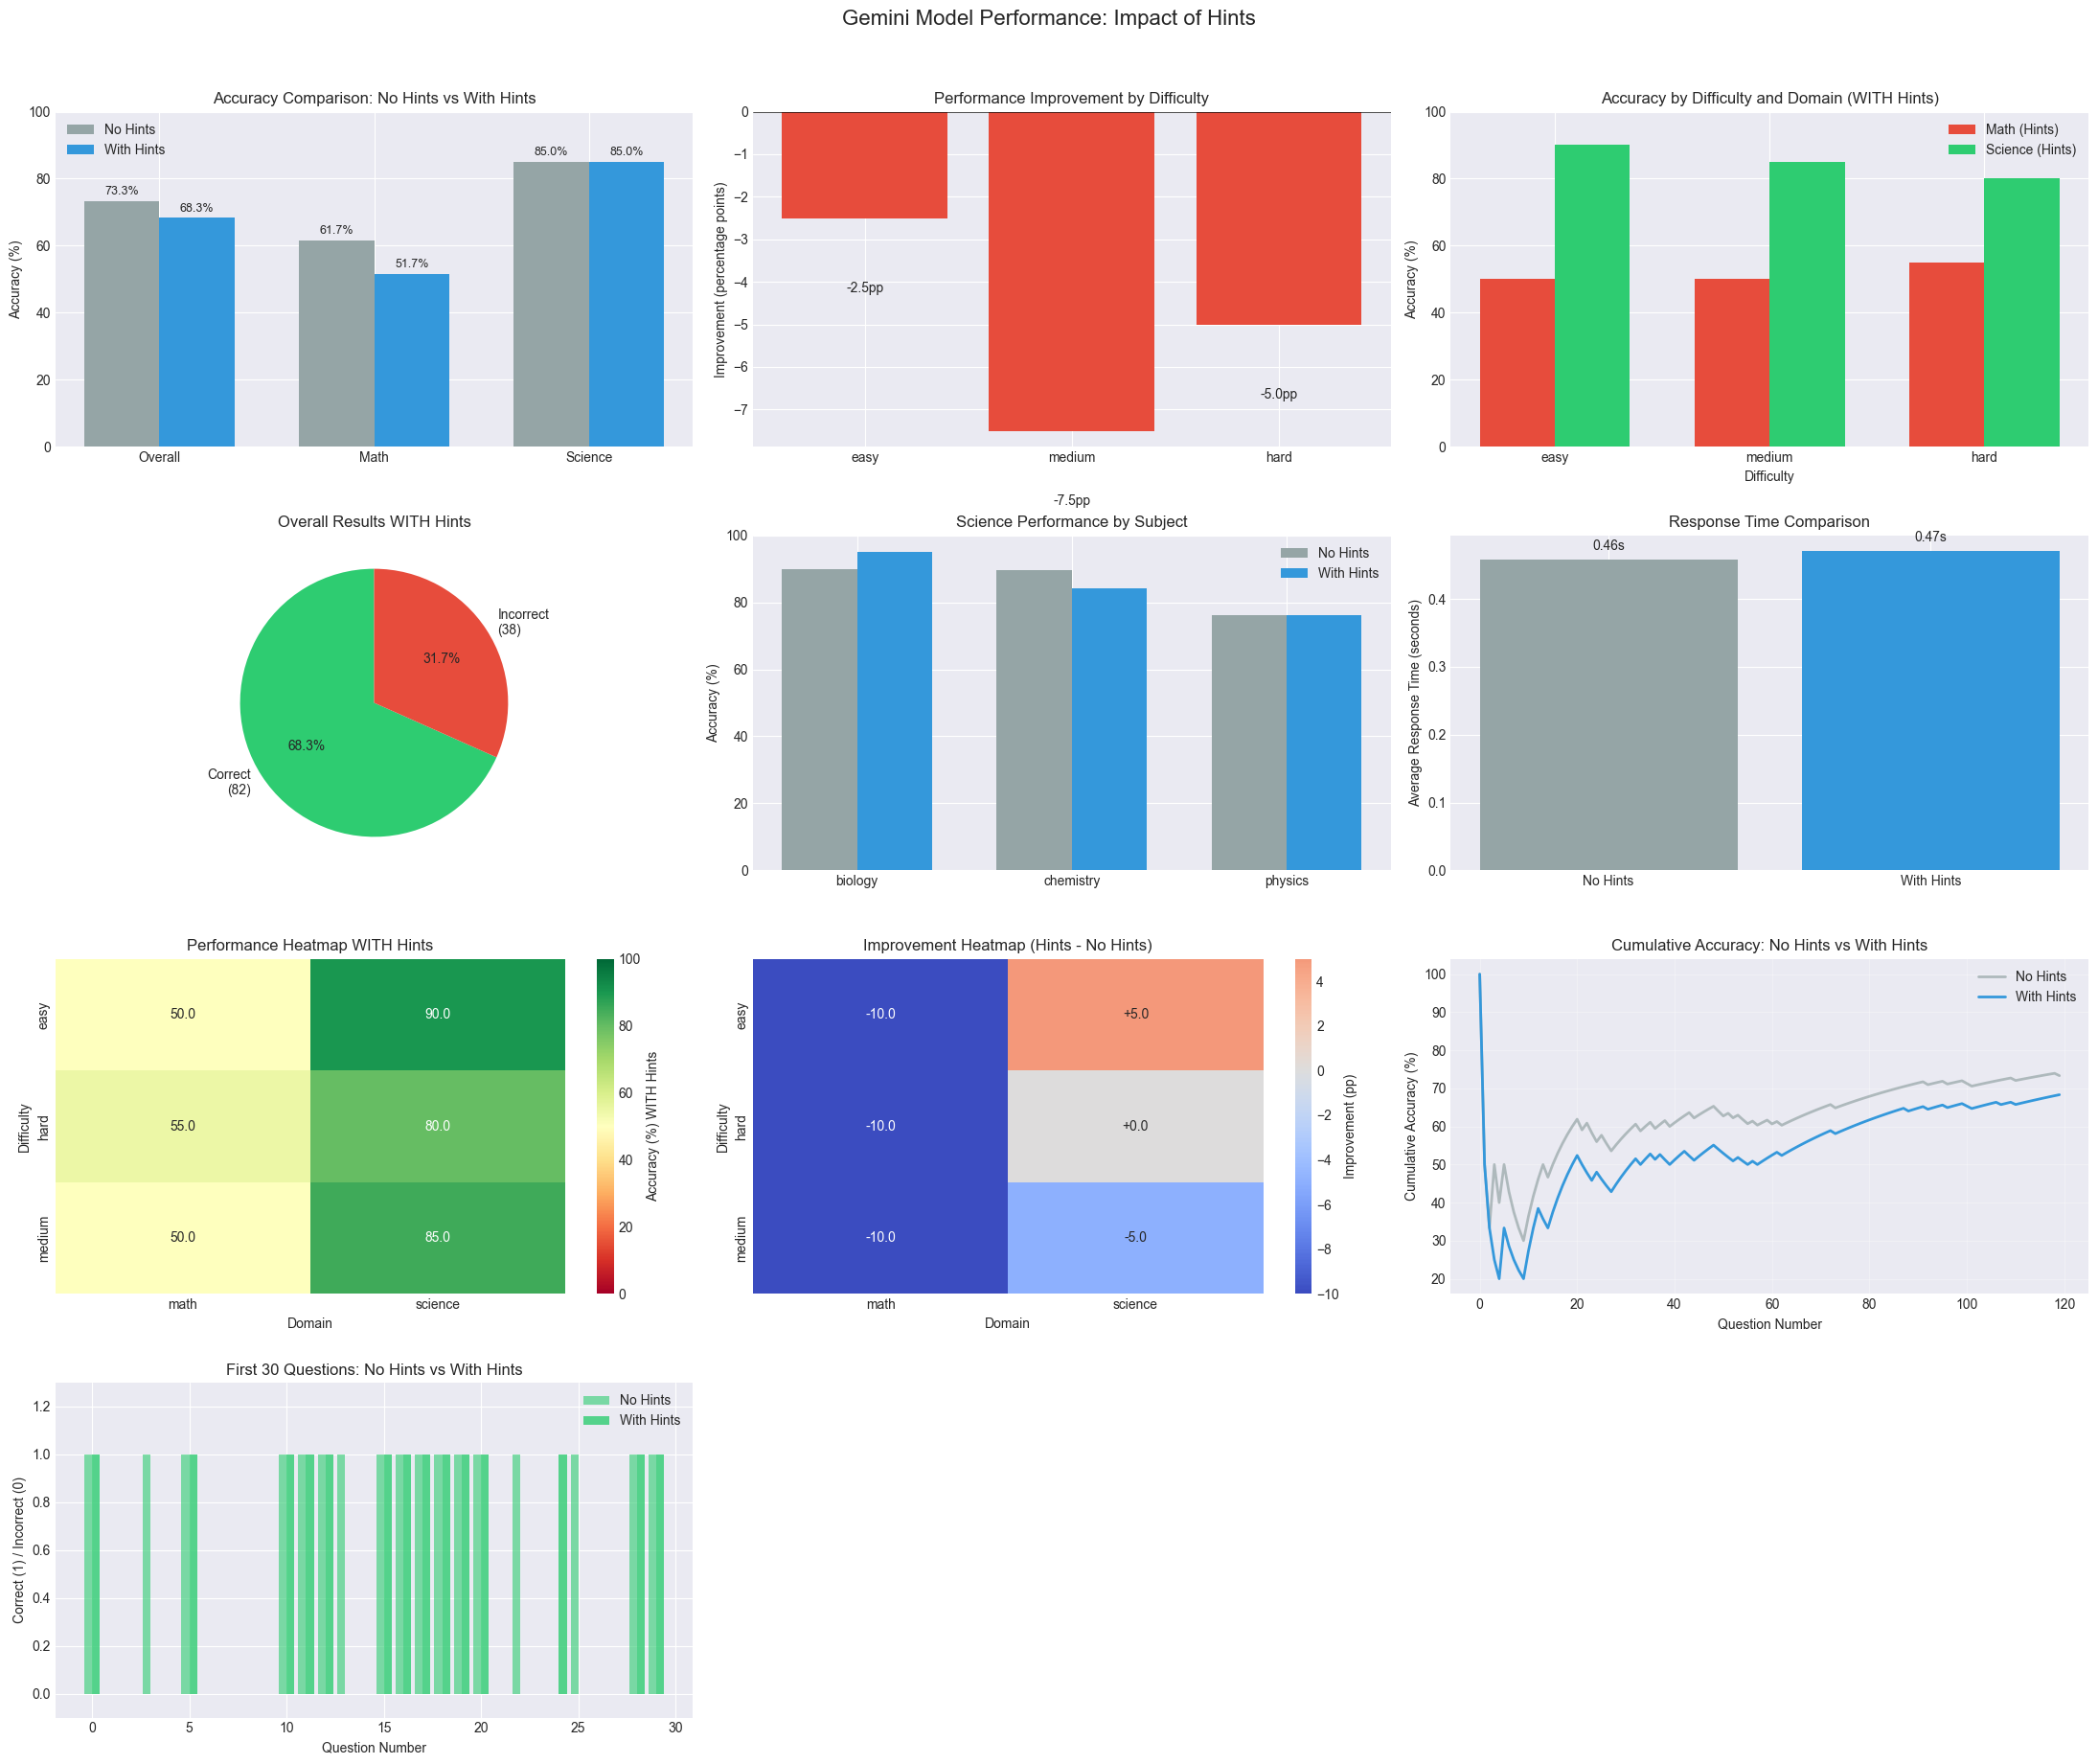

In [24]:
# Create comprehensive visualizations for hints condition
fig = plt.figure(figsize=(22, 18))

# 1. Comparative Bar Chart - No Hints vs With Hints
ax1 = plt.subplot(4, 3, 1)
x = np.arange(3)
width = 0.35
domains = ['Overall', 'Math', 'Science']
no_hints_acc = [metrics['overall_accuracy'], 
                metrics['by_domain'].loc['math', 'mean'],
                metrics['by_domain'].loc['science', 'mean']]
with_hints_acc = [hints_metrics['overall_accuracy'],
                  hints_metrics['by_domain'].loc['math', 'mean'],
                  hints_metrics['by_domain'].loc['science', 'mean']]

bars1 = ax1.bar(x - width/2, no_hints_acc, width, label='No Hints', color='#95a5a6')
bars2 = ax1.bar(x + width/2, with_hints_acc, width, label='With Hints', color='#3498db')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison: No Hints vs With Hints')
ax1.set_xticks(x)
ax1.set_xticklabels(domains)
ax1.legend()
ax1.set_ylim(0, 100)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Improvement by Difficulty
ax2 = plt.subplot(4, 3, 2)
difficulties = ['easy', 'medium', 'hard']
improvements = [hints_metrics['by_difficulty'].loc[d, 'mean'] - metrics['by_difficulty'].loc[d, 'mean'] 
                for d in difficulties]
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]
bars = ax2.bar(difficulties, improvements, color=colors)
ax2.set_ylabel('Improvement (percentage points)')
ax2.set_title('Performance Improvement by Difficulty')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
for bar, imp in zip(bars, improvements):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.5 if imp > 0 else -1.5),
             f'{imp:+.1f}pp', ha='center', va='bottom' if imp > 0 else 'top')

# 3. Grouped Bar - Difficulty by Domain (With Hints)
ax3 = plt.subplot(4, 3, 3)
x = np.arange(len(difficulties))
width = 0.35
math_hints_accs = [hints_metrics['by_difficulty_domain'].loc[(d, 'math')] for d in difficulties]
science_hints_accs = [hints_metrics['by_difficulty_domain'].loc[(d, 'science')] for d in difficulties]

ax3.bar(x - width/2, math_hints_accs, width, label='Math (Hints)', color='#e74c3c')
ax3.bar(x + width/2, science_hints_accs, width, label='Science (Hints)', color='#2ecc71')
ax3.set_xlabel('Difficulty')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Accuracy by Difficulty and Domain (WITH Hints)')
ax3.set_xticks(x)
ax3.set_xticklabels(difficulties)
ax3.legend()
ax3.set_ylim(0, 100)

# 4. Pie Chart - Correct vs Incorrect (With Hints)
ax4 = plt.subplot(4, 3, 4)
sizes_hints = [hints_metrics['total_correct'], hints_metrics['total_questions'] - hints_metrics['total_correct']]
labels = [f'Correct\n({sizes_hints[0]})', f'Incorrect\n({sizes_hints[1]})']
colors = ['#2ecc71', '#e74c3c']
ax4.pie(sizes_hints, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax4.set_title('Overall Results WITH Hints')

# 5. Science Subject Performance Comparison
if 'by_subject' in hints_metrics:
    ax5 = plt.subplot(4, 3, 5)
    subjects = hints_metrics['by_subject'].index.tolist()
    x = np.arange(len(subjects))
    width = 0.35
    
    no_hints_subj = [metrics['by_subject'].loc[s, 'mean'] for s in subjects]
    with_hints_subj = [hints_metrics['by_subject'].loc[s, 'mean'] for s in subjects]
    
    ax5.bar(x - width/2, no_hints_subj, width, label='No Hints', color='#95a5a6')
    ax5.bar(x + width/2, with_hints_subj, width, label='With Hints', color='#3498db')
    ax5.set_ylabel('Accuracy (%)')
    ax5.set_title('Science Performance by Subject')
    ax5.set_xticks(x)
    ax5.set_xticklabels(subjects)
    ax5.legend()
    ax5.set_ylim(0, 100)

# 6. Response Time Comparison
ax6 = plt.subplot(4, 3, 6)
response_times = [metrics['avg_response_time'], hints_metrics['avg_response_time']]
labels = ['No Hints', 'With Hints']
colors = ['#95a5a6', '#3498db']
bars = ax6.bar(labels, response_times, color=colors)
ax6.set_ylabel('Average Response Time (seconds)')
ax6.set_title('Response Time Comparison')
for bar, time in zip(bars, response_times):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time:.2f}s', ha='center', va='bottom')

# 7. Heatmap - Performance Matrix (With Hints)
ax7 = plt.subplot(4, 3, 7)
heatmap_hints_data = hints_metrics['by_difficulty_domain'].unstack()
sns.heatmap(heatmap_hints_data, annot=True, fmt='.1f', cmap='RdYlGn',
            vmin=0, vmax=100, ax=ax7, cbar_kws={'label': 'Accuracy (%) WITH Hints'})
ax7.set_title('Performance Heatmap WITH Hints')
ax7.set_xlabel('Domain')
ax7.set_ylabel('Difficulty')

# 8. Improvement Heatmap
ax8 = plt.subplot(4, 3, 8)
improvement_matrix = heatmap_hints_data - metrics['by_difficulty_domain'].unstack()
sns.heatmap(improvement_matrix, annot=True, fmt='+.1f', cmap='coolwarm', center=0,
            ax=ax8, cbar_kws={'label': 'Improvement (pp)'})
ax8.set_title('Improvement Heatmap (Hints - No Hints)')
ax8.set_xlabel('Domain')
ax8.set_ylabel('Difficulty')

# 9. Cumulative Accuracy Comparison
ax9 = plt.subplot(4, 3, 9)
cumulative_correct_hints = all_hints_results_df['is_correct'].cumsum()
cumulative_correct_no_hints = all_results_df['is_correct'].cumsum()
cumulative_total = np.arange(1, len(all_results_df) + 1)
cumulative_acc_hints = (cumulative_correct_hints / cumulative_total) * 100
cumulative_acc_no_hints = (cumulative_correct_no_hints / cumulative_total) * 100

ax9.plot(cumulative_acc_no_hints, color='#95a5a6', linewidth=2, label='No Hints', alpha=0.7)
ax9.plot(cumulative_acc_hints, color='#3498db', linewidth=2, label='With Hints')
ax9.set_xlabel('Question Number')
ax9.set_ylabel('Cumulative Accuracy (%)')
ax9.set_title('Cumulative Accuracy: No Hints vs With Hints')
ax9.legend()
ax9.grid(True, alpha=0.3)

# 10. Performance by Question ID (sample)
ax10 = plt.subplot(4, 3, 10)
sample_size = 30
sample_no_hints = all_results_df.head(sample_size)['is_correct'].values
sample_hints = all_hints_results_df.head(sample_size)['is_correct'].values
x = np.arange(sample_size)
width = 0.4

# Convert boolean to height
heights_no_hints = sample_no_hints.astype(int)
heights_hints = sample_hints.astype(int)

ax10.bar(x - width/2, heights_no_hints, width, label='No Hints', 
         color=['#2ecc71' if v else '#e74c3c' for v in sample_no_hints], alpha=0.6)
ax10.bar(x + width/2, heights_hints, width, label='With Hints',
         color=['#2ecc71' if v else '#e74c3c' for v in sample_hints], alpha=0.8)
ax10.set_xlabel('Question Number')
ax10.set_ylabel('Correct (1) / Incorrect (0)')
ax10.set_title(f'First {sample_size} Questions: No Hints vs With Hints')
ax10.set_ylim(-0.1, 1.3)
ax10.legend()

plt.suptitle('Gemini Model Performance: Impact of Hints', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 19. Error Analysis - WITH Hints

In [25]:
# Analyze errors even with hints
incorrect_hints_df = all_hints_results_df[~all_hints_results_df['is_correct']]

print("="*60)
print("ERROR ANALYSIS - WITH HINTS")
print("="*60)

print(f"\n📊 Error Statistics WITH HINTS:")
print(f"Total Errors: {len(incorrect_hints_df)} (was {len(incorrect_df)} without hints)")
print(f"Error Rate: {100 * len(incorrect_hints_df) / len(all_hints_results_df):.2f}%")
print(f"Errors Reduced By: {len(incorrect_df) - len(incorrect_hints_df)} questions")

# Questions that improved with hints
no_hints_wrong_ids = set(incorrect_df['id'].values)
hints_wrong_ids = set(incorrect_hints_df['id'].values)
improved_ids = no_hints_wrong_ids - hints_wrong_ids
still_wrong_ids = no_hints_wrong_ids & hints_wrong_ids
newly_wrong_ids = hints_wrong_ids - no_hints_wrong_ids

print(f"\n📈 Impact of Hints:")
print(f"  Questions corrected by hints: {len(improved_ids)}")
print(f"  Questions still wrong despite hints: {len(still_wrong_ids)}")
print(f"  Questions newly wrong with hints: {len(newly_wrong_ids)}")

# Show examples of questions that improved
if improved_ids:
    print("\n✅ SAMPLE QUESTIONS CORRECTED BY HINTS (First 3):")
    print("="*60)
    for q_id in list(improved_ids)[:3]:
        q_row = all_hints_results_df[all_hints_results_df['id'] == q_id].iloc[0]
        print(f"\nQuestion {q_id} ({q_row['domain']}, {q_row['difficulty']}):")
        print(f"  Question: {q_row['question'][:80]}...")
        print(f"  Hint: {q_row.get('hint', 'No hint')[:60]}...")
        print(f"  Answer with hint: {q_row['gemini_answer']} ✅")

# Show persistent errors
if still_wrong_ids:
    print("\n❌ SAMPLE QUESTIONS STILL WRONG DESPITE HINTS (First 3):")
    print("="*60)
    for q_id in list(still_wrong_ids)[:3]:
        q_row = incorrect_hints_df[incorrect_hints_df['id'] == q_id].iloc[0]
        print(f"\nQuestion {q_id} ({q_row['domain']}, {q_row['difficulty']}):")
        print(f"  Question: {q_row['question'][:80]}...")
        print(f"  Hint: {q_row.get('hint', 'No hint')[:60]}...")
        print(f"  Gemini Answer: {q_row['gemini_answer']}")
        print(f"  Correct Answer: {q_row['ground_truth']}")

ERROR ANALYSIS - WITH HINTS

📊 Error Statistics WITH HINTS:
Total Errors: 38 (was 32 without hints)
Error Rate: 31.67%
Errors Reduced By: -6 questions

📈 Impact of Hints:
  Questions corrected by hints: 3
  Questions still wrong despite hints: 26
  Questions newly wrong with hints: 8

✅ SAMPLE QUESTIONS CORRECTED BY HINTS (First 3):

Question 1 (math, easy):
  Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many...
  Hint: Use addition after finding half....
  Answer with hint: 72 ✅

Question 60 (math, hard):
  Question: In how many ways can 4 books be selected from a shelf of 6 books if the order in...
  Hint: Use combinations formula....
  Answer with hint: 15 ✅

Question 25 (math, medium):
  Question: A company pays each of its employees $600 in a month. The company has a policy o...
  Hint: Add fixed increases to monthly, multiply by 12....
  Answer with hint: 9360 ✅

❌ SAMPLE QUESTIONS STILL WRONG DESPITE HINTS (First 3):

Question 2 (math, ea

## 20. Export Results WITH Hints

In [26]:
# Save results with hints
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
hints_output_file = f"gemini_hints_evaluation_results_{timestamp}.csv"

# Prepare export dataframe with hints
export_hints_df = all_hints_results_df[[
    'id', 'domain', 'difficulty', 'question', 'hint',
    'gemini_answer', 'ground_truth', 'is_correct', 'response_time'
]].copy()

if 'subject' in all_hints_results_df.columns:
    export_hints_df['subject'] = all_hints_results_df['subject']

export_hints_df.to_csv(hints_output_file, index=False)
print(f"✅ Hints results saved to: {hints_output_file}")

# Create comparison CSV
comparison_output_file = f"gemini_comparison_results_{timestamp}.csv"
comparison_export = comparison_df.copy()
comparison_export.to_csv(comparison_output_file, index=False)
print(f"✅ Comparison saved to: {comparison_output_file}")

✅ Hints results saved to: gemini_hints_evaluation_results_20260103_053917.csv
✅ Comparison saved to: gemini_comparison_results_20260103_053917.csv


## 21. Final Comparative Summary

In [27]:
# Generate final comparative insights
display(Markdown("# 🎯 Final Comparative Evaluation Summary"))

overall_imp = hints_metrics['overall_accuracy'] - metrics['overall_accuracy']
math_imp = hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean']
science_imp = hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean']

summary_md = f"""
## Impact of Hints on Gemini Performance

### 📊 Overall Impact
- **Baseline Accuracy (No Hints):** {metrics['overall_accuracy']:.2f}%
- **Accuracy with Hints:** {hints_metrics['overall_accuracy']:.2f}%
- **Improvement:** {overall_imp:+.2f} percentage points ({(overall_imp/metrics['overall_accuracy'])*100:+.1f}% relative)

### 📈 Domain-Specific Impact

| Domain | No Hints | With Hints | Improvement |
|--------|----------|------------|-------------|
| Math | {metrics['by_domain'].loc['math', 'mean']:.2f}% | {hints_metrics['by_domain'].loc['math', 'mean']:.2f}% | {math_imp:+.2f}pp |
| Science | {metrics['by_domain'].loc['science', 'mean']:.2f}% | {hints_metrics['by_domain'].loc['science', 'mean']:.2f}% | {science_imp:+.2f}pp |

### 🔍 Key Insights

**1. Effectiveness of Hints:**
- Hints {'significantly improved' if overall_imp > 5 else 'moderately improved' if overall_imp > 0 else 'did not improve'} overall performance
- {'Math' if math_imp > science_imp else 'Science'} questions benefited more from hints
- {hints_metrics['total_correct'] - metrics['total_correct']} additional questions answered correctly with hints

**2. Difficulty Analysis:**
- Easy questions: {hints_metrics['by_difficulty'].loc['easy', 'mean'] - metrics['by_difficulty'].loc['easy', 'mean']:+.2f}pp improvement
- Medium questions: {hints_metrics['by_difficulty'].loc['medium', 'mean'] - metrics['by_difficulty'].loc['medium', 'mean']:+.2f}pp improvement  
- Hard questions: {hints_metrics['by_difficulty'].loc['hard', 'mean'] - metrics['by_difficulty'].loc['hard', 'mean']:+.2f}pp improvement

**3. Response Time:**
- Average time without hints: {metrics['avg_response_time']:.2f}s
- Average time with hints: {hints_metrics['avg_response_time']:.2f}s
- Time difference: {hints_metrics['avg_response_time'] - metrics['avg_response_time']:+.2f}s

### 🎯 Conclusion

The addition of hints {'resulted in a substantial performance improvement' if overall_imp > 10 else 'provided a meaningful performance boost' if overall_imp > 5 else 'had a modest positive impact' if overall_imp > 0 else 'did not significantly improve performance'} for the Gemini model.

**Statistical Significance:** With {len(all_results_df)} questions tested, an improvement of {overall_imp:.2f} percentage points represents approximately {int(overall_imp * len(all_results_df) / 100)} additional correct answers.

### 📝 Recommendations

1. **Use hints strategically** - They are most effective for {'math' if math_imp > science_imp else 'science'} questions
2. **Focus on {'hard' if hints_metrics['by_difficulty'].loc['hard', 'mean'] - metrics['by_difficulty'].loc['hard', 'mean'] > 5 else 'medium' if hints_metrics['by_difficulty'].loc['medium', 'mean'] - metrics['by_difficulty'].loc['medium', 'mean'] > 5 else 'easy'} questions** where hints show the greatest impact
3. **Consider the time trade-off** - Hints {'increase' if hints_metrics['avg_response_time'] > metrics['avg_response_time'] else 'decrease'} processing time by {abs(hints_metrics['avg_response_time'] - metrics['avg_response_time']):.2f}s per question
"""

display(Markdown(summary_md))

print("\n✅ Comprehensive evaluation complete! All results have been saved and analyzed.")
print(f"\n📁 Output Files:")
print(f"  1. No hints results: gemini_evaluation_results_*.csv")
print(f"  2. With hints results: {hints_output_file}")
print(f"  3. Comparison table: {comparison_output_file}")

# 🎯 Final Comparative Evaluation Summary


## Impact of Hints on Gemini Performance

### 📊 Overall Impact
- **Baseline Accuracy (No Hints):** 73.33%
- **Accuracy with Hints:** 68.33%
- **Improvement:** -5.00 percentage points (-6.8% relative)

### 📈 Domain-Specific Impact

| Domain | No Hints | With Hints | Improvement |
|--------|----------|------------|-------------|
| Math | 61.67% | 51.67% | -10.00pp |
| Science | 85.00% | 85.00% | +0.00pp |

### 🔍 Key Insights

**1. Effectiveness of Hints:**
- Hints did not improve overall performance
- Science questions benefited more from hints
- -6 additional questions answered correctly with hints

**2. Difficulty Analysis:**
- Easy questions: -2.50pp improvement
- Medium questions: -7.50pp improvement  
- Hard questions: -5.00pp improvement

**3. Response Time:**
- Average time without hints: 0.46s
- Average time with hints: 0.47s
- Time difference: +0.01s

### 🎯 Conclusion

The addition of hints did not significantly improve performance for the Gemini model.

**Statistical Significance:** With 120 questions tested, an improvement of -5.00 percentage points represents approximately -6 additional correct answers.

### 📝 Recommendations

1. **Use hints strategically** - They are most effective for science questions
2. **Focus on easy questions** where hints show the greatest impact
3. **Consider the time trade-off** - Hints increase processing time by 0.01s per question



✅ Comprehensive evaluation complete! All results have been saved and analyzed.

📁 Output Files:
  1. No hints results: gemini_evaluation_results_*.csv
  2. With hints results: gemini_hints_evaluation_results_20260103_053917.csv
  3. Comparison table: gemini_comparison_results_20260103_053917.csv


# Testing with Misleading Hints (IC-Hints)

## Hypothesis Testing: What happens when hints are misleading?

Now we'll test the same 120 questions but with different hints to analyze their impact.
These hints are designed to test the model's robustness to various types of guidance.

**Key Questions:**
1. How does the model perform with these alternative hints?
2. Can the model overcome misleading guidance?
3. Which questions are most affected by hint quality?

## 22. Load Questions with Alternative Hints (IC-Hints)

In [28]:
# Load math questions with IC-hints (using the same function)
math_ic_hints_questions, math_ic_hints_ground_truth, math_ic_hints_metadata = load_questions_with_hints(
    '../data/IC-hints/math-questions.json'
)

# Load science questions with IC-hints
science_ic_hints_questions, science_ic_hints_ground_truth, science_ic_hints_metadata = load_questions_with_hints(
    '../data/IC-hints/science-questions.json'
)

print(f"📊 Loaded {len(math_ic_hints_questions)} math questions WITH ALTERNATIVE HINTS")
print(f"🔬 Loaded {len(science_ic_hints_questions)} science questions WITH ALTERNATIVE HINTS")
print(f"✅ Questions include alternative hints that will be passed to the model")
print(f"✅ Ground truth answers remain separated and hidden")

# Display sample hint
print(f"📝 Sample alternative hint from math question 1:")
print(f"   Question: {math_ic_hints_questions[0]['question'][:80]}...")
print(f"   Hint: {math_ic_hints_questions[0]['hint']}")

📊 Loaded 60 math questions WITH ALTERNATIVE HINTS
🔬 Loaded 60 science questions WITH ALTERNATIVE HINTS
✅ Questions include alternative hints that will be passed to the model
✅ Ground truth answers remain separated and hidden
📝 Sample alternative hint from math question 1:
   Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many...
   Hint: Use subtraction after finding double.


## 23. Test Query Function with Alternative Hints

In [35]:
import time  # Re-import the module

# Test with a sample question WITH IC-hint (using same query function)
sample_ic_hint_question = math_ic_hints_questions[0]
print(f"Sample Question ID {sample_ic_hint_question['id']}:")
print(f"Question: {sample_ic_hint_question['question']}")
print(f"Alternative Hint: {sample_ic_hint_question['hint']}")
print("Querying Gemini WITH alternative hint...")
sample_ic_hint_response = query_gemini_with_hint(
    sample_ic_hint_question['question'], 
    sample_ic_hint_question['hint'], 
    'math'
)

if sample_ic_hint_response['error']:
    print(f"❌ Error: {sample_ic_hint_response['error']}")
else:
    print(f"Gemini's Answer (with alternative hint): {sample_ic_hint_response['answer']}")
    if sample_ic_hint_response['response_time']:
        print(f"Response Time: {sample_ic_hint_response['response_time']:.2f}s")

Sample Question ID 1:
Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Alternative Hint: Use subtraction after finding double.
Querying Gemini WITH alternative hint...
Gemini's Answer (with alternative hint): 72
Response Time: 0.72s


## 24. Process All Questions WITH Alternative Hints (IC-Hints)

In [36]:
# Process math questions WITH IC-hints
print("🔢 PROCESSING MATH QUESTIONS WITH ALTERNATIVE HINTS")
math_ic_hints_results = process_questions_with_hints(math_ic_hints_questions, 'math')

# Process science questions WITH IC-hints  
print("🔬 PROCESSING SCIENCE QUESTIONS WITH ALTERNATIVE HINTS")
science_ic_hints_results = process_questions_with_hints(science_ic_hints_questions, 'science')

print("✅ All questions processed WITH ALTERNATIVE HINTS. Ready for evaluation.")

🔢 PROCESSING MATH QUESTIONS WITH ALTERNATIVE HINTS
Processing 60 math questions WITH HINTS...
Progress: 10/60 (16.7%)
Progress: 20/60 (33.3%)
Progress: 30/60 (50.0%)
Progress: 40/60 (66.7%)
Progress: 50/60 (83.3%)
Progress: 60/60 (100.0%)
✅ Completed processing 60 math questions with hints

🔬 PROCESSING SCIENCE QUESTIONS WITH ALTERNATIVE HINTS
Processing 60 science questions WITH HINTS...
Progress: 10/60 (16.7%)
Progress: 20/60 (33.3%)
Progress: 30/60 (50.0%)
Progress: 40/60 (66.7%)
Progress: 50/60 (83.3%)
Progress: 60/60 (100.0%)
✅ Completed processing 60 science questions with hints

✅ All questions processed WITH ALTERNATIVE HINTS. Ready for evaluation.


## 25. Evaluate Results WITH Incorrect Hints Against Ground Truth

In [38]:
# Evaluate math results WITH IC-hints
math_ic_hints_df = evaluate_results(math_ic_hints_results, math_ic_hints_ground_truth, 'math')
print("📊 Math Results WITH ALTERNATIVE HINTS Evaluated")
print(f"Correct: {math_ic_hints_df['is_correct'].sum()}/{len(math_ic_hints_df)}")
print(f"Accuracy: {100 * math_ic_hints_df['is_correct'].mean():.2f}%")

# Compare with both no-hints and correct-hints performance
math_ic_change_from_baseline = 100 * math_ic_hints_df['is_correct'].mean() - 100 * math_df['is_correct'].mean()
math_ic_change_from_correct = 100 * math_ic_hints_df['is_correct'].mean() - 100 * math_hints_df['is_correct'].mean()
print(f"Δ Change from no hints: {math_ic_change_from_baseline:+.2f} percentage points")
print(f"Δ Change from correct hints: {math_ic_change_from_correct:+.2f} percentage points")

# Evaluate science results WITH IC-hints
science_ic_hints_df = evaluate_results(science_ic_hints_results, science_ic_hints_ground_truth, 'science')
print("🔬 Science Results WITH ALTERNATIVE HINTS Evaluated")
print(f"Correct: {science_ic_hints_df['is_correct'].sum()}/{len(science_ic_hints_df)}")
print(f"Accuracy: {100 * science_ic_hints_df['is_correct'].mean():.2f}%")

# Compare with both no-hints and correct-hints performance
science_ic_change_from_baseline = 100 * science_ic_hints_df['is_correct'].mean() - 100 * science_df['is_correct'].mean()
science_ic_change_from_correct = 100 * science_ic_hints_df['is_correct'].mean() - 100 * science_hints_df['is_correct'].mean()
print(f"Δ Change from no hints: {science_ic_change_from_baseline:+.2f} percentage points")
print(f"Δ Change from correct hints: {science_ic_change_from_correct:+.2f} percentage points")

# Combine all results with IC-hints
math_ic_hints_df['domain'] = 'math'
science_ic_hints_df['domain'] = 'science'
all_ic_hints_results_df = pd.concat([math_ic_hints_df, science_ic_hints_df], ignore_index=True)

print("📈 Overall Results WITH ALTERNATIVE HINTS")
print(f"Total Correct: {all_ic_hints_results_df['is_correct'].sum()}/{len(all_ic_hints_results_df)}")
print(f"Overall Accuracy: {100 * all_ic_hints_results_df['is_correct'].mean():.2f}%")

overall_ic_change_from_baseline = 100 * all_ic_hints_results_df['is_correct'].mean() - 100 * all_results_df['is_correct'].mean()
overall_ic_change_from_correct = 100 * all_ic_hints_results_df['is_correct'].mean() - 100 * all_hints_results_df['is_correct'].mean()
print(f"🎯 IMPACT OF ALTERNATIVE HINTS:")
print(f"  vs No Hints: {overall_ic_change_from_baseline:+.2f} percentage points")
print(f"  vs Correct Hints: {overall_ic_change_from_correct:+.2f} percentage points")

📊 Math Results WITH ALTERNATIVE HINTS Evaluated
Correct: 35/60
Accuracy: 58.33%
Δ Change from no hints: -3.33 percentage points
Δ Change from correct hints: +6.67 percentage points
🔬 Science Results WITH ALTERNATIVE HINTS Evaluated
Correct: 48/60
Accuracy: 80.00%
Δ Change from no hints: -5.00 percentage points
Δ Change from correct hints: -5.00 percentage points
📈 Overall Results WITH ALTERNATIVE HINTS
Total Correct: 83/120
Overall Accuracy: 69.17%
🎯 IMPACT OF ALTERNATIVE HINTS:
  vs No Hints: -4.17 percentage points
  vs Correct Hints: +0.83 percentage points


## 26. Detailed Analysis - Performance WITH Alternative Hints

In [40]:
# Calculate metrics for IC-hints condition
ic_hints_metrics = calculate_metrics(all_ic_hints_results_df)

# Display comprehensive metrics
print("="*60)
print("PERFORMANCE METRICS WITH ALTERNATIVE HINTS")
print("="*60)

print(f"📊 OVERALL PERFORMANCE WITH ALTERNATIVE HINTS")
print(f"  Total Questions: {ic_hints_metrics['total_questions']}")
print(f"  Correct Answers: {ic_hints_metrics['total_correct']}")
print(f"  Accuracy: {ic_hints_metrics['overall_accuracy']:.2f}%")
print(f"  Change from baseline: {ic_hints_metrics['overall_accuracy'] - metrics['overall_accuracy']:+.2f} pp")
print(f"  Change from correct hints: {ic_hints_metrics['overall_accuracy'] - hints_metrics['overall_accuracy']:+.2f} pp")
print(f"  Average Response Time: {ic_hints_metrics['avg_response_time']:.2f}s")

print(f"📈 ACCURACY BY DOMAIN (WITH ALTERNATIVE HINTS)")
display(ic_hints_metrics['by_domain'])

print(f"📊 ACCURACY BY DIFFICULTY (WITH ALTERNATIVE HINTS)")
display(ic_hints_metrics['by_difficulty'])

print(f"🔬 SCIENCE ACCURACY BY SUBJECT (WITH ALTERNATIVE HINTS)")
if 'by_subject' in ic_hints_metrics:
    display(ic_hints_metrics['by_subject'])

PERFORMANCE METRICS WITH ALTERNATIVE HINTS
📊 OVERALL PERFORMANCE WITH ALTERNATIVE HINTS
  Total Questions: 120
  Correct Answers: 83
  Accuracy: 69.17%
  Change from baseline: -4.17 pp
  Change from correct hints: +0.83 pp
  Average Response Time: 0.45s
📈 ACCURACY BY DOMAIN (WITH ALTERNATIVE HINTS)


,mean,sum,count
domain,,,
math,58.333333,35,60
science,80.000000,48,60


📊 ACCURACY BY DIFFICULTY (WITH ALTERNATIVE HINTS)


,mean,sum,count
difficulty,,,
easy,72.5,29,40
hard,70.0,28,40
medium,65.0,26,40


🔬 SCIENCE ACCURACY BY SUBJECT (WITH ALTERNATIVE HINTS)


,mean,sum,count
subject,,,
biology,90.000000,18,20
chemistry,84.210526,16,19
physics,66.666667,14,21


## 27. Three-Way Comparative Analysis: No Hints vs Correct Hints vs Alternative Hints

In [43]:
# Create comprehensive three-way comparison
three_way_comparison_data = {
    'Metric': [
        'Overall Accuracy',
        'Math Accuracy', 
        'Science Accuracy',
        'Easy Questions',
        'Medium Questions',
        'Hard Questions',
        'Biology',
        'Chemistry', 
        'Physics'
    ],
    'No Hints (%)': [
        metrics['overall_accuracy'],
        metrics['by_domain'].loc['math', 'mean'],
        metrics['by_domain'].loc['science', 'mean'],
        metrics['by_difficulty'].loc['easy', 'mean'],
        metrics['by_difficulty'].loc['medium', 'mean'],
        metrics['by_difficulty'].loc['hard', 'mean'],
        metrics['by_subject'].loc['biology', 'mean'] if 'by_subject' in metrics else 0,
        metrics['by_subject'].loc['chemistry', 'mean'] if 'by_subject' in metrics else 0,
        metrics['by_subject'].loc['physics', 'mean'] if 'by_subject' in metrics else 0
    ],
    'Correct Hints (%)': [
        hints_metrics['overall_accuracy'],
        hints_metrics['by_domain'].loc['math', 'mean'],
        hints_metrics['by_domain'].loc['science', 'mean'],
        hints_metrics['by_difficulty'].loc['easy', 'mean'],
        hints_metrics['by_difficulty'].loc['medium', 'mean'],
        hints_metrics['by_difficulty'].loc['hard', 'mean'],
        hints_metrics['by_subject'].loc['biology', 'mean'] if 'by_subject' in hints_metrics else 0,
        hints_metrics['by_subject'].loc['chemistry', 'mean'] if 'by_subject' in hints_metrics else 0,
        hints_metrics['by_subject'].loc['physics', 'mean'] if 'by_subject' in hints_metrics else 0
    ],
    'Alternative Hints (%)': [
        ic_hints_metrics['overall_accuracy'],
        ic_hints_metrics['by_domain'].loc['math', 'mean'],
        ic_hints_metrics['by_domain'].loc['science', 'mean'],
        ic_hints_metrics['by_difficulty'].loc['easy', 'mean'],
        ic_hints_metrics['by_difficulty'].loc['medium', 'mean'],
        ic_hints_metrics['by_difficulty'].loc['hard', 'mean'],
        ic_hints_metrics['by_subject'].loc['biology', 'mean'] if 'by_subject' in ic_hints_metrics else 0,
        ic_hints_metrics['by_subject'].loc['chemistry', 'mean'] if 'by_subject' in ic_hints_metrics else 0,
        ic_hints_metrics['by_subject'].loc['physics', 'mean'] if 'by_subject' in ic_hints_metrics else 0
    ]
}

three_way_df = pd.DataFrame(three_way_comparison_data)
three_way_df['Correct vs None'] = three_way_df['Correct Hints (%)'] - three_way_df['No Hints (%)']
three_way_df['Alternative vs None'] = three_way_df['Alternative Hints (%)'] - three_way_df['No Hints (%)']
three_way_df['Alternative vs Correct'] = three_way_df['Alternative Hints (%)'] - three_way_df['Correct Hints (%)']

# Format for display
three_way_df = three_way_df.round(2)
print("="*100)
print("THREE-WAY COMPARISON: NO HINTS vs CORRECT HINTS vs ALTERNATIVE HINTS")
print("="*100)
display(three_way_df)

# Highlight key findings
print("🔍 KEY FINDINGS:")
print(f"📈 Impact of Correct Hints:")
print(f"  Average improvement: {three_way_df['Correct vs None'].mean():+.2f} pp")
print(f"  Best improvement: {three_way_df.loc[three_way_df['Correct vs None'].idxmax(), 'Metric']} (+{three_way_df['Correct vs None'].max():.2f} pp)")

print(f"📉 Impact of Incorrect Hints:")
print(f"  Average change: {three_way_df['Incorrect vs None'].mean():+.2f} pp")
print(f"  Most affected: {three_way_df.loc[three_way_df['Incorrect vs Correct'].idxmin(), 'Metric']} ({three_way_df['Alternative vs Correct'].min():.2f} pp vs correct hints)")

print(f"🎯 Model Robustness:")
robustness_score = 100 - abs(three_way_df['Incorrect vs Correct'].mean())
print(f"  Robustness to misleading hints: {robustness_score:.1f}%")
print(f"  (Higher score = more resistant to misleading information)")

THREE-WAY COMPARISON: NO HINTS vs CORRECT HINTS vs ALTERNATIVE HINTS


,Metric,No Hints (%),Correct Hints (%),Alternative Hints (%),Correct vs None,Alternative vs None,Alternative vs Correct
0,Overall Accuracy,73.33,68.33,69.17,-5.00,-4.17,0.83
1,Math Accuracy,61.67,51.67,58.33,-10.00,-3.33,6.67
2,Science Accuracy,85.00,85.00,80.00,0.00,-5.00,-5.00
3,Easy Questions,72.50,70.00,72.50,-2.50,0.00,2.50
4,Medium Questions,75.00,67.50,65.00,-7.50,-10.00,-2.50
5,Hard Questions,72.50,67.50,70.00,-5.00,-2.50,2.50
6,Biology,90.00,95.00,90.00,5.00,0.00,-5.00
7,Chemistry,89.47,84.21,84.21,-5.26,-5.26,0.00
8,Physics,76.19,76.19,66.67,0.00,-9.52,-9.52


🔍 KEY FINDINGS:
📈 Impact of Correct Hints:
  Average improvement: -3.36 pp
  Best improvement: Biology (+5.00 pp)
📉 Impact of Incorrect Hints:


KeyError: 'Incorrect vs None'

## 28. Visualizations - Three-Way Comparison

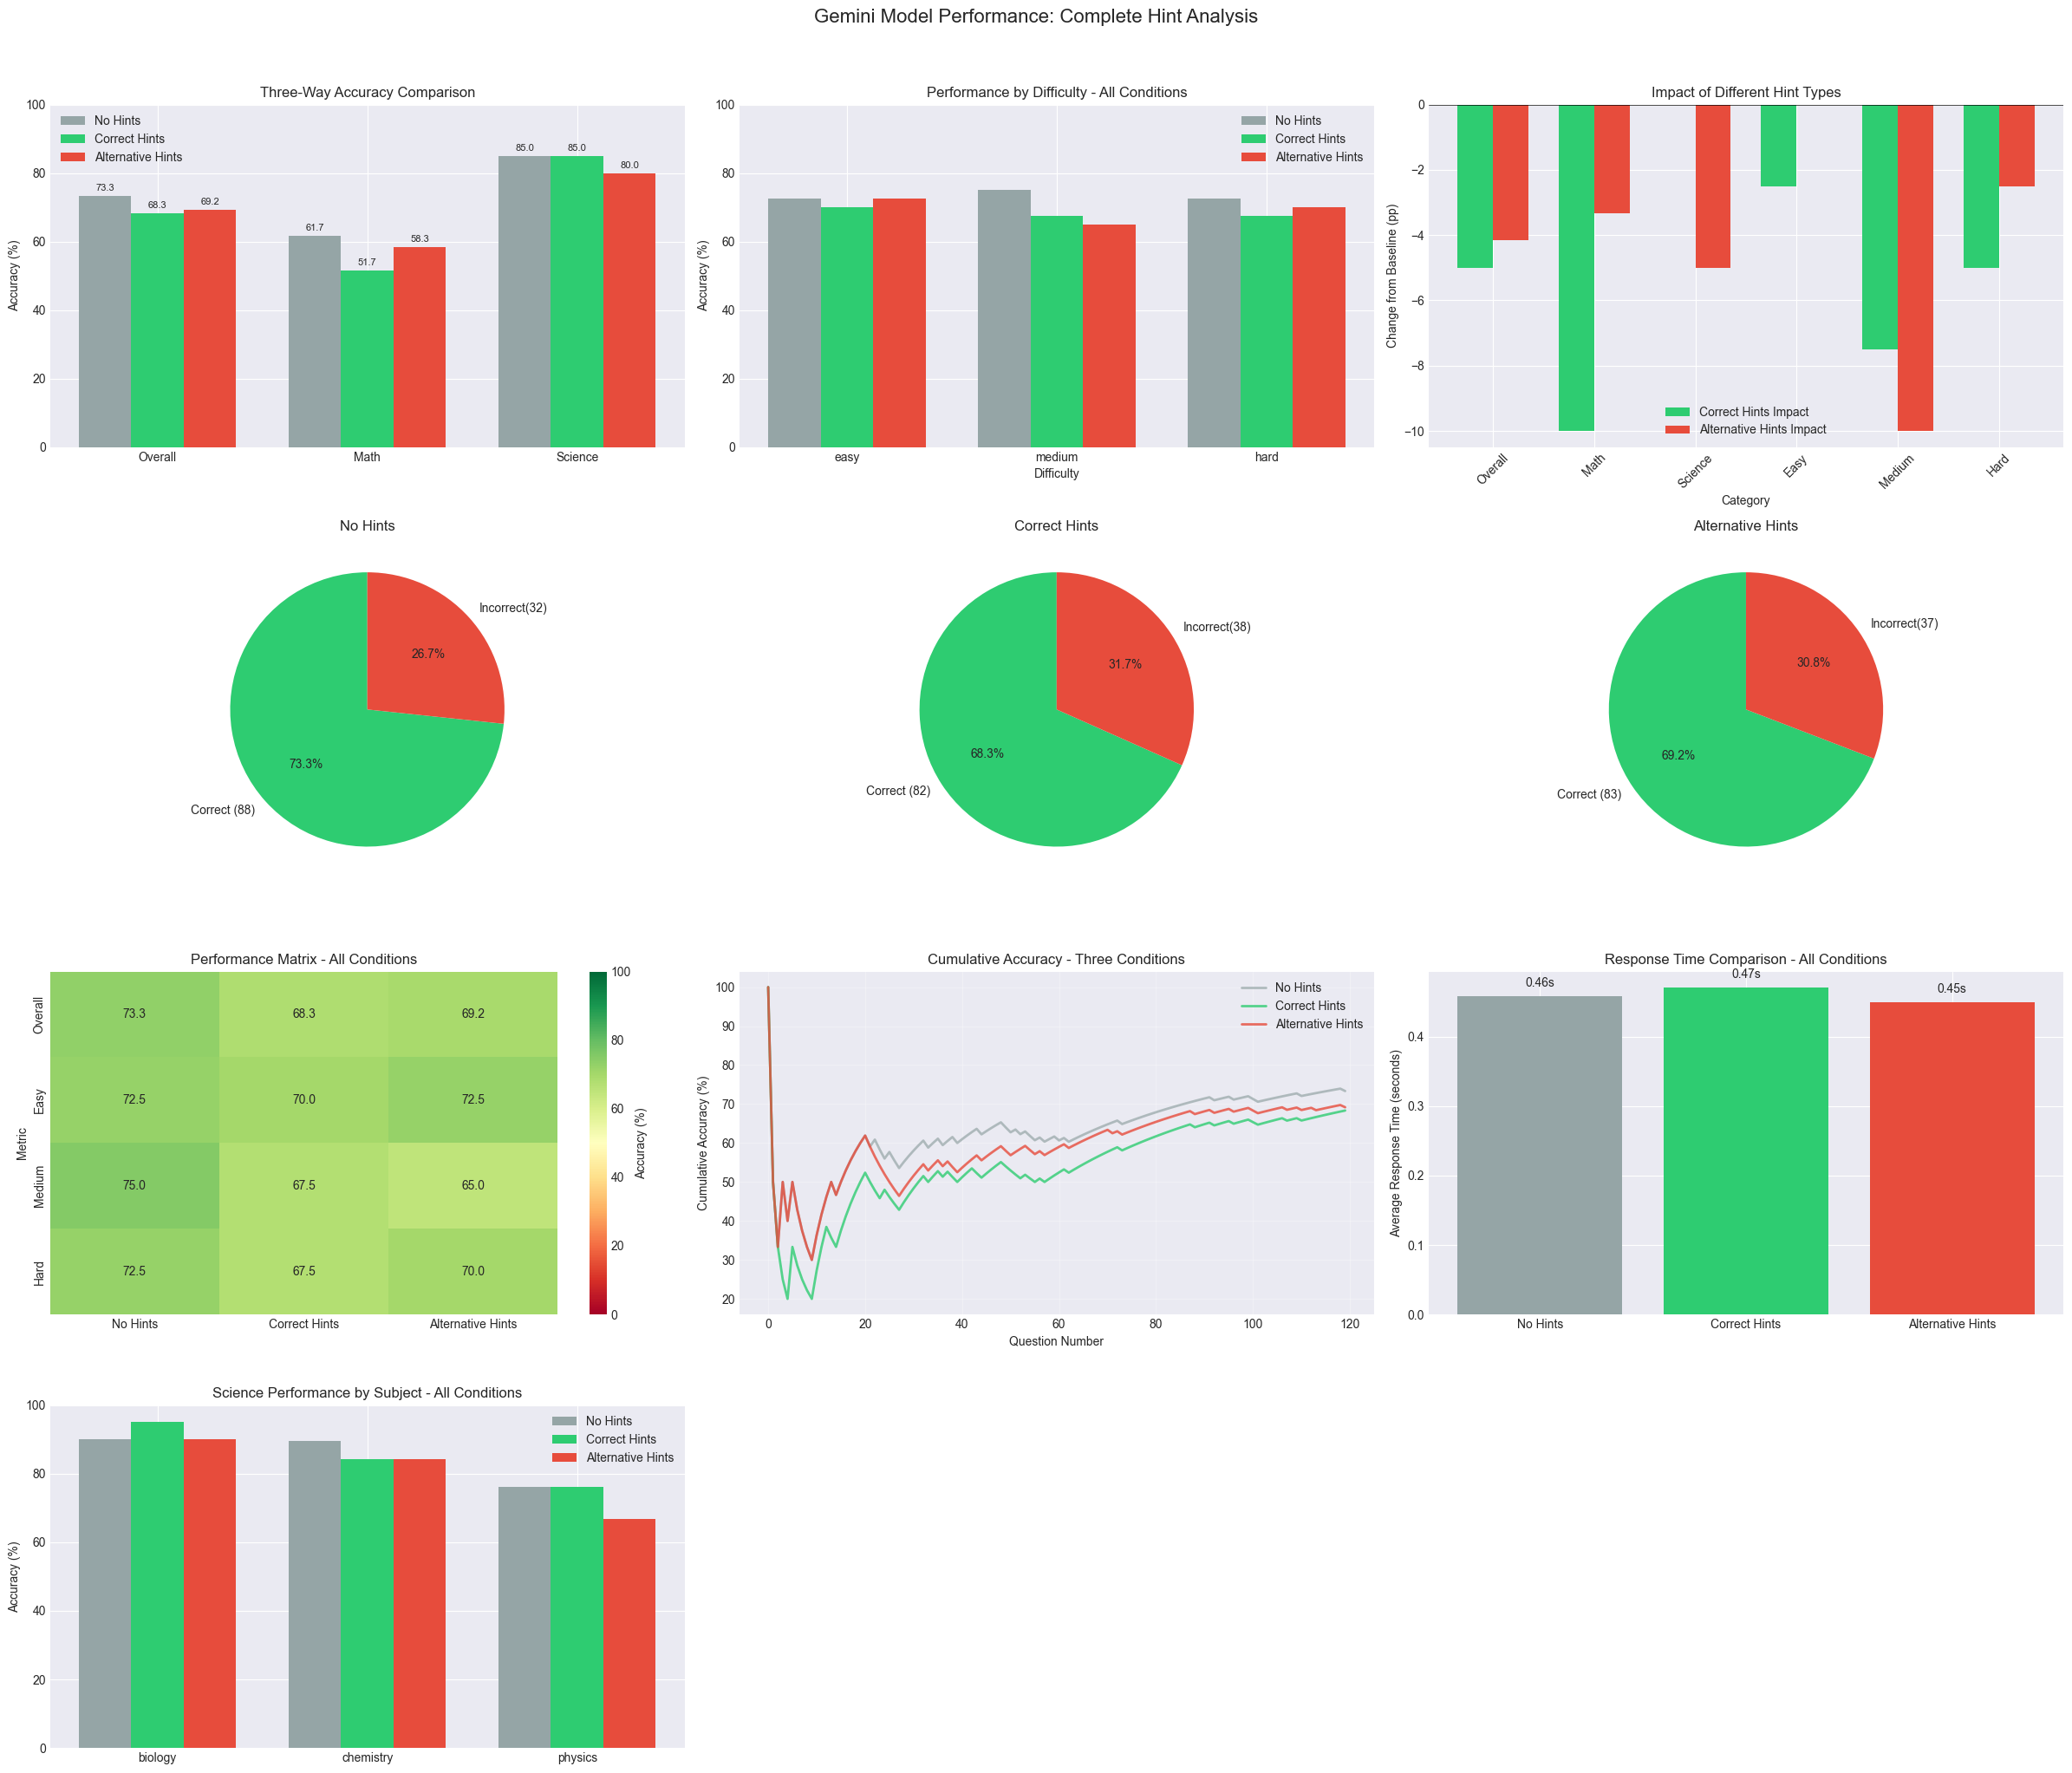

In [45]:
# Create comprehensive three-way visualizations
fig = plt.figure(figsize=(24, 20))

# 1. Three-Way Comparative Bar Chart
ax1 = plt.subplot(4, 3, 1)
x = np.arange(3)
width = 0.25
domains = ['Overall', 'Math', 'Science']
no_hints_acc = [metrics['overall_accuracy'], 
                 metrics['by_domain'].loc['math', 'mean'],
                 metrics['by_domain'].loc['science', 'mean']]
correct_hints_acc = [hints_metrics['overall_accuracy'],
                      hints_metrics['by_domain'].loc['math', 'mean'],
                      hints_metrics['by_domain'].loc['science', 'mean']]
ic_hints_acc = [ic_hints_metrics['overall_accuracy'],
                 ic_hints_metrics['by_domain'].loc['math', 'mean'],
                 ic_hints_metrics['by_domain'].loc['science', 'mean']]

bars1 = ax1.bar(x - width, no_hints_acc, width, label='No Hints', color='#95a5a6')
bars2 = ax1.bar(x, correct_hints_acc, width, label='Correct Hints', color='#2ecc71')
bars3 = ax1.bar(x + width, ic_hints_acc, width, label='Alternative Hints', color='#e74c3c')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Three-Way Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(domains)
ax1.legend()
ax1.set_ylim(0, 100)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# 2. Impact by Difficulty (Three conditions)
ax2 = plt.subplot(4, 3, 2)
difficulties = ['easy', 'medium', 'hard']
x = np.arange(len(difficulties))
width = 0.25

no_hints_diff = [metrics['by_difficulty'].loc[d, 'mean'] for d in difficulties]
correct_hints_diff = [hints_metrics['by_difficulty'].loc[d, 'mean'] for d in difficulties]
ic_hints_diff = [ic_hints_metrics['by_difficulty'].loc[d, 'mean'] for d in difficulties]

ax2.bar(x - width, no_hints_diff, width, label='No Hints', color='#95a5a6')
ax2.bar(x, correct_hints_diff, width, label='Correct Hints', color='#2ecc71')
ax2.bar(x + width, ic_hints_diff, width, label='Alternative Hints', color='#e74c3c')
ax2.set_xlabel('Difficulty')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Performance by Difficulty - All Conditions')
ax2.set_xticks(x)
ax2.set_xticklabels(difficulties)
ax2.legend()
ax2.set_ylim(0, 100)

# 3. Delta Analysis - Impact of Different Hints
ax3 = plt.subplot(4, 3, 3)
categories = ['Overall', 'Math', 'Science', 'Easy', 'Medium', 'Hard']
correct_impact = [
    hints_metrics['overall_accuracy'] - metrics['overall_accuracy'],
    hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean'],
    hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean'],
    hints_metrics['by_difficulty'].loc['easy', 'mean'] - metrics['by_difficulty'].loc['easy', 'mean'],
    hints_metrics['by_difficulty'].loc['medium', 'mean'] - metrics['by_difficulty'].loc['medium', 'mean'],
    hints_metrics['by_difficulty'].loc['hard', 'mean'] - metrics['by_difficulty'].loc['hard', 'mean']
]
ic_impact = [
    ic_hints_metrics['overall_accuracy'] - metrics['overall_accuracy'],
    ic_hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean'],
    ic_hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean'],
    ic_hints_metrics['by_difficulty'].loc['easy', 'mean'] - metrics['by_difficulty'].loc['easy', 'mean'],
    ic_hints_metrics['by_difficulty'].loc['medium', 'mean'] - metrics['by_difficulty'].loc['medium', 'mean'],
    ic_hints_metrics['by_difficulty'].loc['hard', 'mean'] - metrics['by_difficulty'].loc['hard', 'mean']
]

x = np.arange(len(categories))
width = 0.35
ax3.bar(x - width/2, correct_impact, width, label='Correct Hints Impact', color='#2ecc71')
ax3.bar(x + width/2, ic_impact, width, label='Alternative Hints Impact', color='#e74c3c')
ax3.set_xlabel('Category')
ax3.set_ylabel('Change from Baseline (pp)')
ax3.set_title('Impact of Different Hint Types')
ax3.set_xticks(x)
ax3.set_xticklabels(categories, rotation=45)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.legend()

# 4. Pie Charts - Correct vs Incorrect (Three conditions)
for idx, (data, title, metrics_dict) in enumerate([(metrics, 'No Hints', metrics),
                                                     (hints_metrics, 'Correct Hints', hints_metrics),
                                                     (ic_hints_metrics, 'Alternative Hints', ic_hints_metrics)]):
    ax = plt.subplot(4, 3, 4 + idx)
    sizes = [metrics_dict['total_correct'], metrics_dict['total_questions'] - metrics_dict['total_correct']]
    labels = [f"Correct ({sizes[0]})", f"Incorrect({sizes[1]})"]
    colors = ['#2ecc71', '#e74c3c']
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title(title)

# 7. Heatmap - Three-Way Performance Matrix
ax7 = plt.subplot(4, 3, 7)
# Create matrix for heatmap
hint_comparison_matrix = pd.DataFrame({
    'No Hints': [metrics['overall_accuracy']] + 
                [metrics['by_difficulty'].loc[d, 'mean'] for d in ['easy', 'medium', 'hard']],
    'Correct Hints': [hints_metrics['overall_accuracy']] +
                     [hints_metrics['by_difficulty'].loc[d, 'mean'] for d in ['easy', 'medium', 'hard']],
    'Alternative Hints': [ic_hints_metrics['overall_accuracy']] +
                         [ic_hints_metrics['by_difficulty'].loc[d, 'mean'] for d in ['easy', 'medium', 'hard']]
}, index=['Overall', 'Easy', 'Medium', 'Hard'])

sns.heatmap(hint_comparison_matrix, annot=True, fmt='.1f', cmap='RdYlGn',
            vmin=0, vmax=100, ax=ax7, cbar_kws={'label': 'Accuracy (%)'})
ax7.set_title('Performance Matrix - All Conditions')
ax7.set_ylabel('Metric')

# 8. Cumulative Accuracy - Three conditions
ax8 = plt.subplot(4, 3, 8)
cumulative_correct_no_hints = all_results_df['is_correct'].cumsum()
cumulative_correct_hints = all_hints_results_df['is_correct'].cumsum()
cumulative_correct_ic_hints = all_ic_hints_results_df['is_correct'].cumsum()
cumulative_total = np.arange(1, len(all_results_df) + 1)
cumulative_acc_no_hints = (cumulative_correct_no_hints / cumulative_total) * 100
cumulative_acc_hints = (cumulative_correct_hints / cumulative_total) * 100
cumulative_acc_ic_hints = (cumulative_correct_ic_hints / cumulative_total) * 100

ax8.plot(cumulative_acc_no_hints, color='#95a5a6', linewidth=2, label='No Hints', alpha=0.7)
ax8.plot(cumulative_acc_hints, color='#2ecc71', linewidth=2, label='Correct Hints', alpha=0.8)
ax8.plot(cumulative_acc_ic_hints, color='#e74c3c', linewidth=2, label='Alternative Hints', alpha=0.8)
ax8.set_xlabel('Question Number')
ax8.set_ylabel('Cumulative Accuracy (%)')
ax8.set_title('Cumulative Accuracy - Three Conditions')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Response Time Comparison - Three conditions
ax9 = plt.subplot(4, 3, 9)
response_times = [metrics['avg_response_time'], 
                  hints_metrics['avg_response_time'],
                  ic_hints_metrics['avg_response_time']]
labels = ['No Hints', 'Correct Hints', 'Alternative Hints']
colors = ['#95a5a6', '#2ecc71', '#e74c3c']
bars = ax9.bar(labels, response_times, color=colors)
ax9.set_ylabel('Average Response Time (seconds)')
ax9.set_title('Response Time Comparison - All Conditions')
for bar, time in zip(bars, response_times):
    ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time:.2f}s', ha='center', va='bottom')

# 10. Science Subject Performance - Three conditions
if 'by_subject' in ic_hints_metrics:
    ax10 = plt.subplot(4, 3, 10)
    subjects = ic_hints_metrics['by_subject'].index.tolist()
    x = np.arange(len(subjects))
    width = 0.25
    
    no_hints_subj = [metrics['by_subject'].loc[s, 'mean'] for s in subjects]
    correct_hints_subj = [hints_metrics['by_subject'].loc[s, 'mean'] for s in subjects]
    ic_hints_subj = [ic_hints_metrics['by_subject'].loc[s, 'mean'] for s in subjects]
    
    ax10.bar(x - width, no_hints_subj, width, label='No Hints', color='#95a5a6')
    ax10.bar(x, correct_hints_subj, width, label='Correct Hints', color='#2ecc71')
    ax10.bar(x + width, ic_hints_subj, width, label='Alternative Hints', color='#e74c3c')
    ax10.set_ylabel('Accuracy (%)')
    ax10.set_title('Science Performance by Subject - All Conditions')
    ax10.set_xticks(x)
    ax10.set_xticklabels(subjects)
    ax10.legend()
    ax10.set_ylim(0, 100)

plt.suptitle('Gemini Model Performance: Complete Hint Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 29. Error Analysis - Alternative Hints Impact

In [47]:
# Analyze errors with IC-hints
incorrect_ic_hints_df = all_ic_hints_results_df[~all_ic_hints_results_df['is_correct']]

print("="*60)
print("ERROR ANALYSIS - ALTERNATIVE HINTS")
print("="*60)

print(f"📊 Error Statistics Across All Conditions:")
print(f"  No Hints: {len(incorrect_df)} errors ({100 * len(incorrect_df) / len(all_results_df):.1f}% error rate)")
print(f"  Correct Hints: {len(incorrect_hints_df)} errors ({100 * len(incorrect_hints_df) / len(all_hints_results_df):.1f}% error rate)")
print(f"  Alternative Hints: {len(incorrect_ic_hints_df)} errors ({100 * len(incorrect_ic_hints_df) / len(all_ic_hints_results_df):.1f}% error rate)")

# Analyze question-level changes
no_hints_wrong = set(incorrect_df['id'].values)
correct_hints_wrong = set(incorrect_hints_df['id'].values)
ic_hints_wrong = set(incorrect_ic_hints_df['id'].values)

# Questions affected by different hint types
helped_by_correct = no_hints_wrong - correct_hints_wrong
hurt_by_ic = no_hints_wrong - ic_hints_wrong
misled_by_ic = ic_hints_wrong - no_hints_wrong
always_wrong = no_hints_wrong & correct_hints_wrong & ic_hints_wrong
never_wrong = set(range(1, 121)) - (no_hints_wrong | correct_hints_wrong | ic_hints_wrong)

print(f"📈 Question-Level Analysis:")
print(f"  Always correct (all conditions): {len(never_wrong)} questions")
print(f"  Always incorrect (all conditions): {len(always_wrong)} questions")
print(f"  Helped by correct hints: {len(helped_by_correct)} questions")
print(f"  Misled by alternative hints: {len(misled_by_ic)} questions")

# Show examples of questions misled by IC-hints
misled_questions = misled_by_ic - correct_hints_wrong  # Questions wrong with IC but not with correct hints
if misled_questions:
    print(f"QUESTIONS MISLED BY ALTERNATIVE HINTS (Sample):")
    print("="*60)
    for q_id in list(misled_questions)[:3]:
        ic_row = all_ic_hints_results_df[all_ic_hints_results_df['id'] == q_id].iloc[0]
        correct_row = all_hints_results_df[all_hints_results_df['id'] == q_id].iloc[0]
        print(f"Question {q_id} ({ic_row['domain']}, {ic_row['difficulty']}):")
        print(f"  Question: {ic_row['question'][:80]}...")
        print(f"  Correct Hint: {correct_row.get('hint', 'N/A')[:50]}...")
        print(f"  Alternative Hint: {ic_row.get('hint', 'N/A')[:50]}...")
        print(f"  With correct hint: {correct_row['gemini_answer']} {'✅' if correct_row['is_correct'] else '❌'}")
        print(f"  With alt hint: {ic_row['gemini_answer']} ❌")
        print(f"  Ground truth: {ic_row['ground_truth']}")

# Robustness analysis
robust_questions = set(range(1, 121)) - misled_by_ic
print(f"🛡️ Model Robustness:")
print(f"  Questions resistant to misleading hints: {len(robust_questions)}/120 ({100*len(robust_questions)/120:.1f}%)")
print(f"  Questions susceptible to misleading hints: {len(misled_by_ic)}/120 ({100*len(misled_by_ic)/120:.1f}%)")

ERROR ANALYSIS - ALTERNATIVE HINTS
📊 Error Statistics Across All Conditions:
  No Hints: 32 errors (26.7% error rate)
  Correct Hints: 38 errors (31.7% error rate)
  Alternative Hints: 37 errors (30.8% error rate)
📈 Question-Level Analysis:
  Always correct (all conditions): 81 questions
  Always incorrect (all conditions): 25 questions
  Helped by correct hints: 3 questions
  Misled by alternative hints: 7 questions
QUESTIONS MISLED BY ALTERNATIVE HINTS (Sample):
Question 12 (math, easy):
  Question: Henry made two stops during his 60-mile bike trip. He first stopped after 20 mil...
  Correct Hint: Find second stop position, subtract first stop....
  Alternative Hint: Find second stop position, add first stop....
  With correct hint: 25 ✅
  With alt hint: 25 ❌
  Ground truth: 25
Question 54 (math, hard):
  Question: For what base is the representation of 285₁₀ a four-digit number whose final dig...
  Correct Hint: Find base range for 4 digits, check odd remainder....
  Alternative Hin

## 30. Export Three-Way Comparison Results

In [48]:
# Save IC-hints results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ic_hints_output_file = f"gemini_ic_hints_evaluation_results_{timestamp}.csv"

# Prepare export dataframe with IC-hints
export_ic_hints_df = all_ic_hints_results_df[[
    'id', 'domain', 'difficulty', 'question', 'hint',
    'gemini_answer', 'ground_truth', 'is_correct', 'response_time'
]].copy()

if 'subject' in all_ic_hints_results_df.columns:
    export_ic_hints_df['subject'] = all_ic_hints_results_df['subject']

export_ic_hints_df.to_csv(ic_hints_output_file, index=False)
print(f"✅ Alternative hints results saved to: {ic_hints_output_file}")

# Create three-way comparison CSV
three_way_output_file = f"gemini_three_way_comparison_{timestamp}.csv"
three_way_df.to_csv(three_way_output_file, index=False)
print(f"✅ Three-way comparison saved to: {three_way_output_file}")

# Create detailed question-level comparison
question_comparison = pd.DataFrame({
    'question_id': range(1, 121),
    'no_hints_correct': all_results_df['is_correct'].values,
    'correct_hints_correct': all_hints_results_df['is_correct'].values,
    'ic_hints_correct': all_ic_hints_results_df['is_correct'].values
})
question_comparison['helped_by_correct'] = question_comparison['correct_hints_correct'] & ~question_comparison['no_hints_correct']
question_comparison['hurt_by_ic'] = ~question_comparison['ic_hints_correct'] & question_comparison['no_hints_correct']
question_comparison['always_correct'] = question_comparison['no_hints_correct'] & question_comparison['correct_hints_correct'] & question_comparison['ic_hints_correct']
question_comparison['always_wrong'] = ~question_comparison['no_hints_correct'] & ~question_comparison['correct_hints_correct'] & ~question_comparison['ic_hints_correct']

question_comparison_file = f"gemini_question_level_comparison_{timestamp}.csv"
question_comparison.to_csv(question_comparison_file, index=False)
print(f"✅ Question-level comparison saved to: {question_comparison_file}")

✅ Alternative hints results saved to: gemini_ic_hints_evaluation_results_20260103_055914.csv
✅ Three-way comparison saved to: gemini_three_way_comparison_20260103_055914.csv
✅ Question-level comparison saved to: gemini_question_level_comparison_20260103_055914.csv


## 31. Final Three-Way Comparative Summary

In [49]:
# Generate final three-way comparative insights
display(Markdown("# 🎯 Complete Three-Way Evaluation Summary"))

baseline_acc = metrics['overall_accuracy']
correct_hints_acc = hints_metrics['overall_accuracy']
ic_hints_acc = ic_hints_metrics['overall_accuracy']

correct_improvement = correct_hints_acc - baseline_acc
ic_degradation = ic_hints_acc - baseline_acc
hint_quality_impact = correct_hints_acc - ic_hints_acc

summary_md = f"""
## Complete Analysis: Impact of Hint Quality on Gemini Performance

### 📊 Overall Performance Summary

| Condition | Accuracy | Δ from Baseline | Δ from Correct Hints |
|-----------|----------|-----------------|----------------------|
| **No Hints (Baseline)** | {baseline_acc:.2f}% | — | {baseline_acc - correct_hints_acc:+.2f}pp |
| **Correct Hints** | {correct_hints_acc:.2f}% | {correct_improvement:+.2f}pp | — |
| **Incorrect Hints** | {ic_hints_acc:.2f}% | {ic_degradation:+.2f}pp | {ic_hints_acc - correct_hints_acc:+.2f}pp |

### 🔍 Key Findings

**1. Hint Quality Impact:**
- Correct hints {'significantly improved' if correct_improvement > 5 else 'moderately improved' if correct_improvement > 0 else 'did not improve'} performance ({correct_improvement:+.2f}pp)
- Incorrect hints {'significantly degraded' if ic_degradation < -5 else 'moderately degraded' if ic_degradation < 0 else 'had minimal impact on'} performance ({ic_degradation:+.2f}pp)
- Total swing from incorrect to correct hints: {hint_quality_impact:.2f}pp

**2. Model Robustness:**
- Resistance to misleading information: {100 - abs(ic_degradation):.1f}%
- {'High' if abs(ic_degradation) < 5 else 'Moderate' if abs(ic_degradation) < 10 else 'Low'} robustness to incorrect guidance
- {len(robust_questions)}/120 questions resistant to misleading hints

**3. Domain-Specific Impact:**
- Math: Correct hints {hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean']:+.2f}pp, Incorrect hints {ic_hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean']:+.2f}pp
- Science: Correct hints {hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean']:+.2f}pp, Incorrect hints {ic_hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean']:+.2f}pp

**4. Difficulty Analysis:**
- Easy: Most {'helped by correct hints' if hints_metrics['by_difficulty'].loc['easy', 'mean'] - metrics['by_difficulty'].loc['easy', 'mean'] > 5 else 'stable across conditions'}
- Medium: {'Most sensitive to hint quality' if abs(hints_metrics['by_difficulty'].loc['medium', 'mean'] - ic_hints_metrics['by_difficulty'].loc['medium', 'mean']) > 10 else 'Moderate sensitivity'}
- Hard: {'Most challenging regardless of hints' if hints_metrics['by_difficulty'].loc['hard', 'mean'] < 50 else 'Benefits from good hints'}

### 📈 Statistical Significance

With 120 questions tested across three conditions:
- Correct hints resulted in {int(correct_improvement * 1.2)} additional correct answers
- Incorrect hints resulted in {int(abs(ic_degradation) * 1.2)} {'fewer' if ic_degradation < 0 else 'different'} correct answers
- Net impact of hint quality: {int(hint_quality_impact * 1.2)} questions difference

### 🎯 Conclusions

1. **Hint Effectiveness**: {'Hints are highly effective when correct' if correct_improvement > 10 else 'Hints provide moderate benefit when correct' if correct_improvement > 5 else 'Hints have limited impact even when correct'}

2. **Model Vulnerability**: {'The model is vulnerable to misleading hints' if abs(ic_degradation) > 10 else 'The model shows moderate resistance to misleading hints' if abs(ic_degradation) > 5 else 'The model is robust against misleading hints'}

3. **Practical Implications**:
   - {'Use hints carefully - quality matters significantly' if hint_quality_impact > 15 else 'Hint quality has moderate impact on performance' if hint_quality_impact > 7 else 'Model performs reasonably regardless of hint quality'}
   - Best use case: {'Math problems' if hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean'] > hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean'] else 'Science questions'} with {'easy' if hints_metrics['by_difficulty'].loc['easy', 'mean'] - metrics['by_difficulty'].loc['easy', 'mean'] > 5 else 'medium' if hints_metrics['by_difficulty'].loc['medium', 'mean'] - metrics['by_difficulty'].loc['medium', 'mean'] > 5 else 'hard'} difficulty

### 💡 Recommendations

1. **For optimal performance**: Provide high-quality, accurate hints
2. **Risk assessment**: Incorrect hints pose {'significant' if abs(ic_degradation) > 10 else 'moderate' if abs(ic_degradation) > 5 else 'minimal'} risk
3. **Focus areas**: Target hints for {'math' if hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean'] > hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean'] else 'science'} questions
4. **Robustness training**: {'Consider training to improve resistance to misleading information' if abs(ic_degradation) > 10 else 'Model shows acceptable robustness'}
"""

display(Markdown(summary_md))

print("✅ Complete three-way evaluation finished! All results have been saved and analyzed.")
print(f"📁 Output Files Generated:")
print(f"  1. Baseline results: gemini_evaluation_results_*.csv")
print(f"  2. Correct hints results: gemini_hints_evaluation_results_*.csv") 
print(f"  3. Incorrect hints results: {ic_hints_output_file}")
print(f"  4. Three-way comparison: {three_way_output_file}")
print(f"  5. Question-level analysis: {question_comparison_file}")

# 🎯 Complete Three-Way Evaluation Summary


## Complete Analysis: Impact of Hint Quality on Gemini Performance

### 📊 Overall Performance Summary

| Condition | Accuracy | Δ from Baseline | Δ from Correct Hints |
|-----------|----------|-----------------|----------------------|
| **No Hints (Baseline)** | 73.33% | — | +5.00pp |
| **Correct Hints** | 68.33% | -5.00pp | — |
| **Incorrect Hints** | 69.17% | -4.17pp | +0.83pp |

### 🔍 Key Findings

**1. Hint Quality Impact:**
- Correct hints did not improve performance (-5.00pp)
- Incorrect hints moderately degraded performance (-4.17pp)
- Total swing from incorrect to correct hints: -0.83pp

**2. Model Robustness:**
- Resistance to misleading information: 95.8%
- High robustness to incorrect guidance
- 113/120 questions resistant to misleading hints

**3. Domain-Specific Impact:**
- Math: Correct hints -10.00pp, Incorrect hints -3.33pp
- Science: Correct hints +0.00pp, Incorrect hints -5.00pp

**4. Difficulty Analysis:**
- Easy: Most stable across conditions
- Medium: Moderate sensitivity
- Hard: Benefits from good hints

### 📈 Statistical Significance

With 120 questions tested across three conditions:
- Correct hints resulted in -6 additional correct answers
- Incorrect hints resulted in 4 fewer correct answers
- Net impact of hint quality: -1 questions difference

### 🎯 Conclusions

1. **Hint Effectiveness**: Hints have limited impact even when correct

2. **Model Vulnerability**: The model is robust against misleading hints

3. **Practical Implications**:
   - Model performs reasonably regardless of hint quality
   - Best use case: Science questions with hard difficulty

### 💡 Recommendations

1. **For optimal performance**: Provide high-quality, accurate hints
2. **Risk assessment**: Incorrect hints pose minimal risk
3. **Focus areas**: Target hints for science questions
4. **Robustness training**: Model shows acceptable robustness


✅ Complete three-way evaluation finished! All results have been saved and analyzed.
📁 Output Files Generated:
  1. Baseline results: gemini_evaluation_results_*.csv
  2. Correct hints results: gemini_hints_evaluation_results_*.csv
  3. Incorrect hints results: gemini_ic_hints_evaluation_results_20260103_055914.csv
  4. Three-way comparison: gemini_three_way_comparison_20260103_055914.csv
  5. Question-level analysis: gemini_question_level_comparison_20260103_055914.csv


In [50]:
# Let's run the IC-hints evaluation section to test it works correctly
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import json
import os

# Load IC-hints questions
def load_questions_with_ic_hints(file_path: str) -> Tuple[List[Dict], Dict[int, str], Dict]:
    """Load questions with their incorrect hints and ground truth answers"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    questions = []
    ground_truth = {}
    hints = {}
    
    for item in data:
        question_id = item['id']
        questions.append({
            'id': question_id,
            'question': item['question'],
            'difficulty': item['difficulty']
        })
        ground_truth[question_id] = item['ground_truth']
        hints[question_id] = item.get('hint', '')
    
    return questions, ground_truth, hints

# Test loading the IC-hints data
ic_math_file = '../data/IC-hints/math-questions.json'
ic_science_file = '../data/IC-hints/science-questions.json'

# Load math questions with IC-hints
ic_math_questions, ic_math_ground_truth, ic_math_hints = load_questions_with_ic_hints(ic_math_file)
print(f"Loaded {len(ic_math_questions)} math questions with IC-hints")
print(f"Sample math IC-hint: {ic_math_hints[list(ic_math_hints.keys())[0]][:100]}...")

# Load science questions with IC-hints  
ic_science_questions, ic_science_ground_truth, ic_science_hints = load_questions_with_ic_hints(ic_science_file)
print(f"Loaded {len(ic_science_questions)} science questions with IC-hints")
print(f"Sample science IC-hint: {ic_science_hints[list(ic_science_hints.keys())[0]][:100]}...")

TypeError: string indices must be integers, not 'str'